In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pbcm-10k-data/pbmc_10k_v3_filtered_feature_bc_matrix (1).h5
/kaggle/input/pbmc-4k/pbmc4k_raw_gene_bc_matrices_h5.h5


In [28]:
!pip install scikit-misc


In [29]:
pip install leidenalg

Note: you may need to restart the kernel to use updated packages.


In [30]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [31]:
!pip install scanpy

In [32]:
pip install scanpy matplotlib seaborn pandas numpy


Note: you may need to restart the kernel to use updated packages.


In [33]:
import itertools
import random
import scipy
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy import sparse
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from torch.amp import autocast, GradScaler 



/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
... storing 'label' as categorical


 Dataset Overview 
Shape (Cells x Genes): (11769, 33538)
First 5 Cell IDs: ['AAACCCAAGCGCCCAT-1', 'AAACCCAAGGTTCCGC-1', 'AAACCCACAGAGTTGG-1', 'AAACCCACAGGTATGG-1', 'AAACCCACATAGTCAC-1']
First 5 Gene Names: ['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3']

Sparsity of expression matrix: 93.71%

 Summary statistics for first 5 genes 
                 mean       std  min  25%  50%  75%  max
MIR1302-2HG  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
FAM138A      0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
OR4F5        0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
AL627309.1   0.005183  0.072984  0.0  0.0  0.0  0.0  2.0
AL627309.3   0.000340  0.018433  0.0  0.0  0.0  0.0  1.0


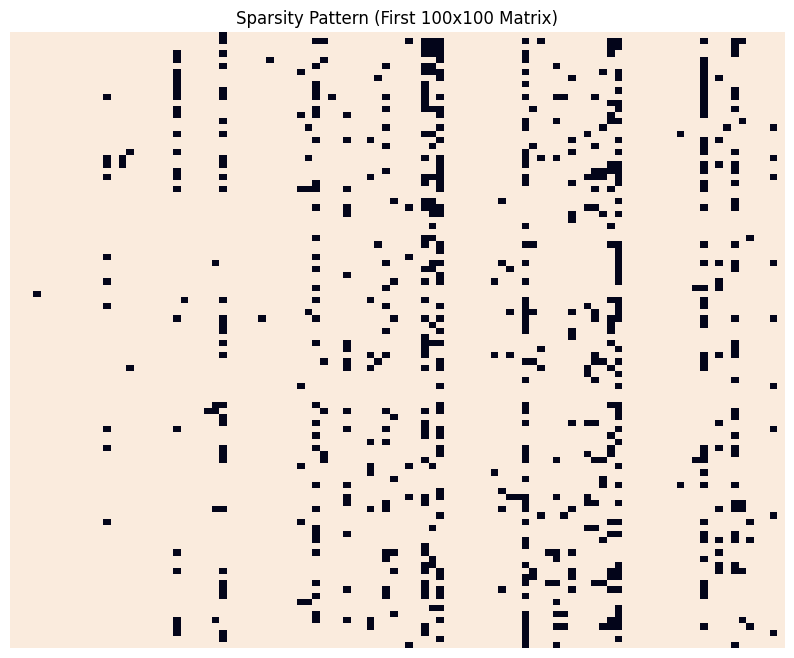

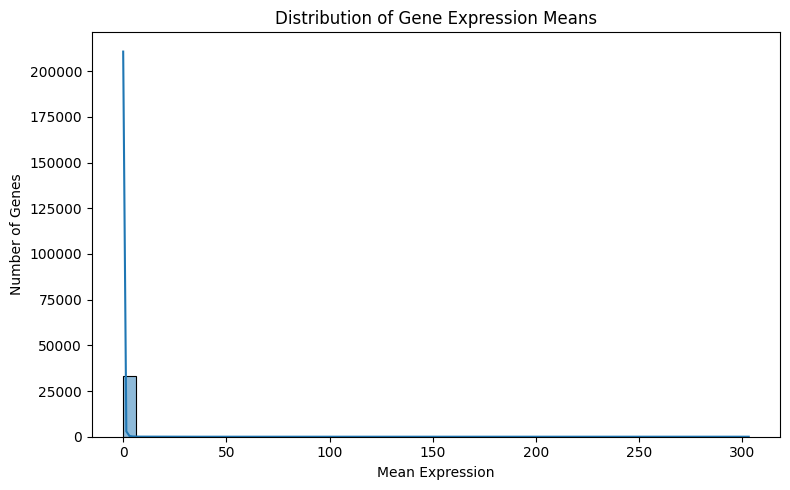


 Class Distribution
label
unknown    11769
Name: count, dtype: int64


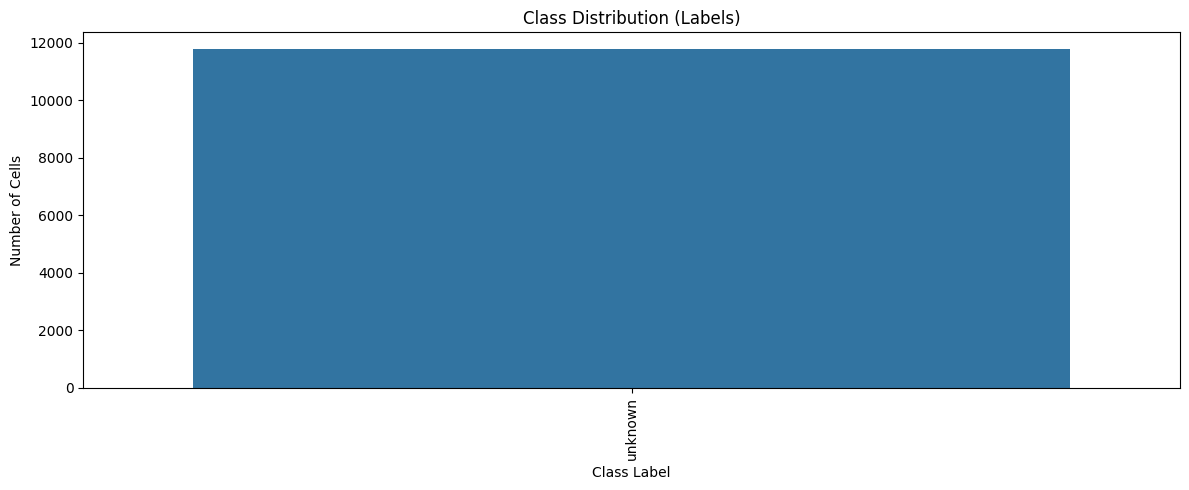

In [34]:

#  Loading the custom HDF5 dataset 
file_path = "/kaggle/input/pbcm-10k-data/pbmc_10k_v3_filtered_feature_bc_matrix (1).h5"
with h5py.File(file_path, 'r') as f:
    if {"X", "cell_name", "gene_name"}.issubset(f.keys()):
       
        X = f["X"][:]
        cell_names = [x.decode() if isinstance(x, (bytes, bytearray)) else str(x) for x in f["cell_name"][:]]
        gene_names = [x.decode() if isinstance(x, (bytes, bytearray)) else str(x) for x in f["gene_name"][:]]
    elif "matrix" in f:
      
        g = f["matrix"]
        data = g["data"][:]
        indices = g["indices"][:]  
        indptr = g["indptr"][:]     
        n_genes, n_cells = map(int, g["shape"][:])

        X_csc = scipy.sparse.csc_matrix((data, indices, indptr), shape=(n_genes, n_cells))
        X = X_csc.transpose().toarray()  # now cells × genes

        barcodes = g["barcodes"][:]
        cell_names = [b.decode() if isinstance(b, (bytes, bytearray)) else str(b) for b in barcodes]

        if "features" in g and "name" in g["features"]:
            gene_names = [n.decode() if isinstance(n, (bytes, bytearray)) else str(n) for n in g["features"]["name"][:]]
        elif "gene_names" in g:
            gene_names = [n.decode() if isinstance(n, (bytes, bytearray)) else str(n) for n in g["gene_names"][:]]
        else:
            gene_names = [f"gene_{i}" for i in range(n_genes)]
    else:
        raise KeyError(
            f"Unrecognized HDF5 layout. Top-level keys: {list(f.keys())}. "
            "Expected either ('X','cell_name','gene_name') or a 'matrix' group (10x format)."
        )

# Building AnnData with raw counts
df = pd.DataFrame(X, index=cell_names, columns=gene_names)
adata = sc.AnnData(df)
adata.write("PBMC_data.h5ad")

# Attaching placeholder labels 
adata.obs["label"] = "unknown"

# Saving AnnData 
adata.write("PBMC_neuron_data_labeled.h5ad")

# Summary Statistics 
print(" Dataset Overview ")
print(f"Shape (Cells x Genes): {adata.shape}")
print(f"First 5 Cell IDs: {adata.obs_names[:5].tolist()}")
print(f"First 5 Gene Names: {adata.var_names[:5].tolist()}")

# Sparsity 
num_zeros = (adata.X == 0).sum()
total = adata.X.size
sparsity = num_zeros / total
print(f"\nSparsity of expression matrix: {sparsity * 100:.2f}%")

# Per-gene summary 
summary_stats = df.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
print("\n Summary statistics for first 5 genes ")
print(summary_stats.head())

# Sparsity Heatmap  
subset = df.iloc[:100, :100]
plt.figure(figsize=(10, 8))
sns.heatmap((subset == 0), cbar=False, xticklabels=False, yticklabels=False)
plt.title("Sparsity Pattern (First 100x100 Matrix)")
plt.show()

#  Gene Mean Distribution 
gene_means = df.mean(axis=0)
plt.figure(figsize=(8, 5))
sns.histplot(gene_means, bins=50, kde=True)
plt.title("Distribution of Gene Expression Means")
plt.xlabel("Mean Expression")
plt.ylabel("Number of Genes")
plt.tight_layout()
plt.show()

# Class Imbalance Check 
label_counts = adata.obs["label"].value_counts().sort_index()
label_counts.index = label_counts.index.astype(str)

print("\n Class Distribution")
print(label_counts.head(10))

plt.figure(figsize=(12, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Class Distribution (Labels)")
plt.xlabel("Class Label")
plt.ylabel("Number of Cells")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of mitochondrial genes detected: 13
Example mitochondrial genes: ['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8']


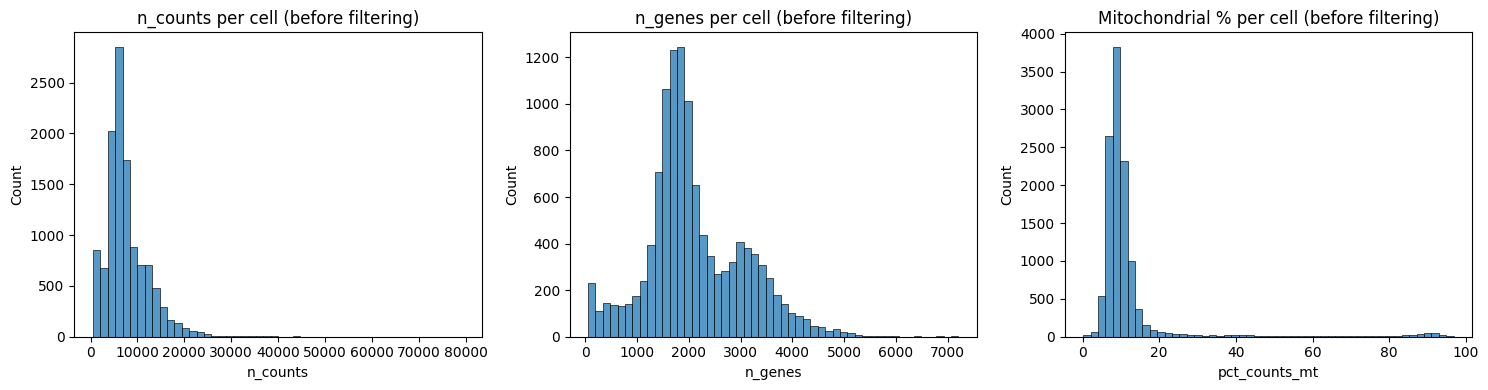

Before filtering: (11769, 33538)


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


After filtering: (10640, 20137)


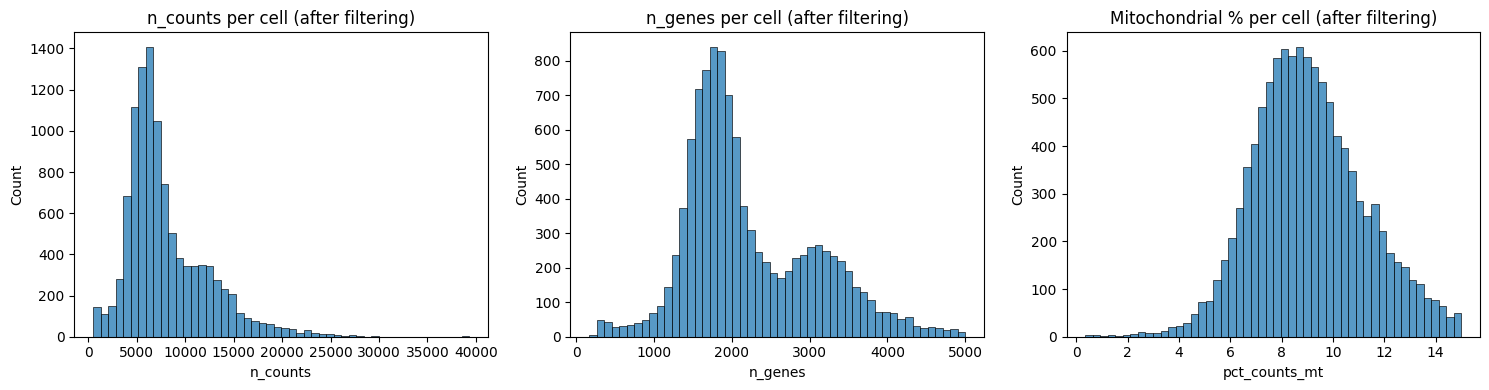

HVGs selected: 2000


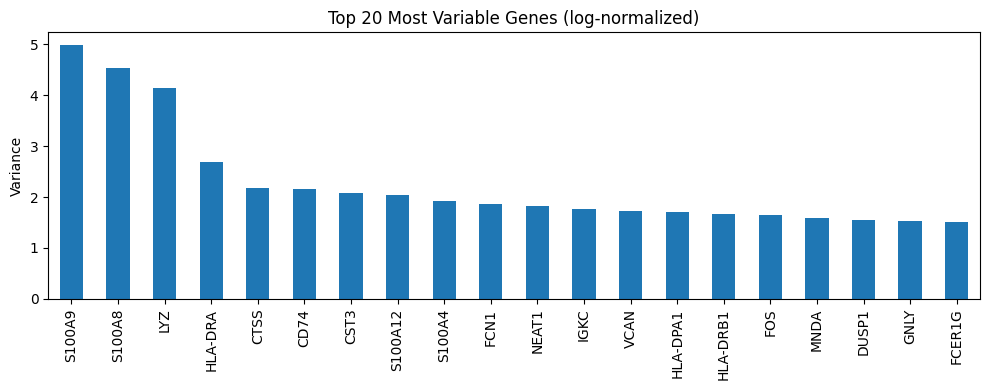

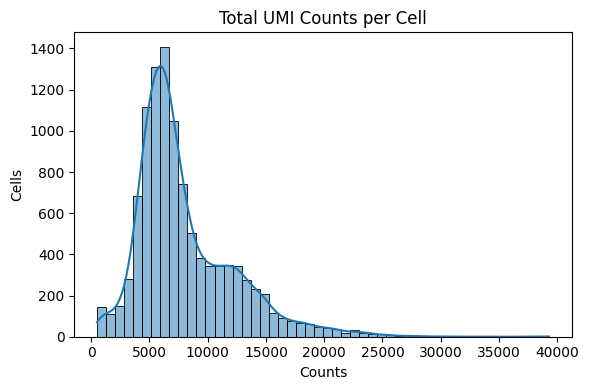

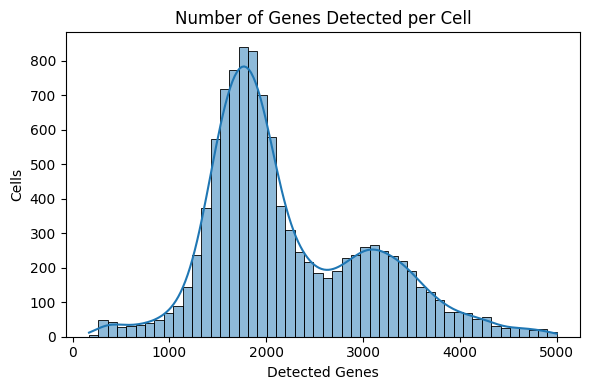

Filtered raw PBMC dataset saved
Log-normalized dataset saved 


In [35]:

# Loading raw AnnData object 
adata = sc.read("PBMC_data.h5ad")
adata.var_names_make_unique()

# Calculating QC metrics 
adata.obs['n_counts'] = adata.X.sum(axis=1).A1 if sparse.issparse(adata.X) else adata.X.sum(axis=1)
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1).A1 if sparse.issparse(adata.X) else (adata.X > 0).sum(axis=1)
adata.var['n_cells'] = (adata.X > 0).sum(axis=0).A1 if sparse.issparse(adata.X) else (adata.X > 0).sum(axis=0)

# Proper Mitochondrial Gene Detection
mt_gene_mask = adata.var_names.str.upper().str.startswith('MT-')
print(f"Number of mitochondrial genes detected: {mt_gene_mask.sum()}")
print("Example mitochondrial genes:", adata.var_names[mt_gene_mask][:5].tolist())
adata.var['mt'] = mt_gene_mask

# Calculating pct_counts_mt 
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

# Visualizing QC metrics BEFORE filtering 
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(adata.obs['n_counts'], bins=50, ax=axs[0])
axs[0].set_title("n_counts per cell (before filtering)")
sns.histplot(adata.obs['n_genes'], bins=50, ax=axs[1])
axs[1].set_title("n_genes per cell (before filtering)")
sns.histplot(adata.obs['pct_counts_mt'], bins=50, ax=axs[2])
axs[2].set_title("Mitochondrial % per cell (before filtering)")
plt.tight_layout()
plt.show()

print(f"Before filtering: {adata.shape}")

# More permissive PBMC QC thresholds 
adata = adata[(adata.obs['n_counts'] >= 300) & (adata.obs['n_counts'] <= 50000), :]
adata = adata[(adata.obs['n_genes'] >= 150) & (adata.obs['n_genes'] <= 5000), :]
adata = adata[adata.obs['pct_counts_mt'] < 15, :]

# Filtering genes
sc.pp.filter_genes(adata, min_cells=3)

print(f"After filtering: {adata.shape}")

# Visualizing QC metrics AFTER filtering 
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(adata.obs['n_counts'], bins=50, ax=axs[0])
axs[0].set_title("n_counts per cell (after filtering)")
sns.histplot(adata.obs['n_genes'], bins=50, ax=axs[1])
axs[1].set_title("n_genes per cell (after filtering)")
sns.histplot(adata.obs['pct_counts_mt'], bins=50, ax=axs[2])
axs[2].set_title("Mitochondrial % per cell (after filtering)")
plt.tight_layout()
plt.show()

# Saving filtered raw counts for SCDCC with ZINB 
adata_raw = adata.copy()
adata_raw.write("PBMC_raw_for_scdcc.h5ad")

#  Log-normalizing 
adata_eda = adata.copy()
sc.pp.normalize_total(adata_eda, target_sum=1e4)
sc.pp.log1p(adata_eda)

#  Highly variable genes 
sc.pp.highly_variable_genes(adata_eda, n_top_genes=2000, flavor='seurat', inplace=True)
print(f"HVGs selected: {adata_eda.var.highly_variable.sum()}")

# Ploting top HVGs 
top_hvg = adata_eda[:, adata_eda.var.highly_variable].to_df().var().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 4))
top_hvg.plot(kind='bar')
plt.title("Top 20 Most Variable Genes (log-normalized)")
plt.ylabel("Variance")
plt.tight_layout()
plt.show()

# Ploting UMI count distribution 
plt.figure(figsize=(6, 4))
sns.histplot(adata.obs['n_counts'], bins=50, kde=True)
plt.title("Total UMI Counts per Cell")
plt.xlabel("Counts")
plt.ylabel("Cells")
plt.tight_layout()
plt.show()

# Ploting gene detection per cell 
plt.figure(figsize=(6, 4))
sns.histplot(adata.obs['n_genes'], bins=50, kde=True)
plt.title("Number of Genes Detected per Cell")
plt.xlabel("Detected Genes")
plt.ylabel("Cells")
plt.tight_layout()
plt.show()

# Saving log-normalized data
adata_eda.write("PBMC_eda_log_norm.h5ad")


print("Filtered raw PBMC dataset saved")
print("Log-normalized dataset saved ")


Shape: (10640, 20137)
First cells: Index(['AAACCCAAGCGCCCAT-1', 'AAACCCAAGGTTCCGC-1', 'AAACCCACAGAGTTGG-1',
       'AAACCCACAGGTATGG-1', 'AAACCCACATAGTCAC-1'],
      dtype='object', name='cell_id')
First genes: Index(['AL627309.1', 'AL627309.3', 'AL669831.5', 'FAM87B', 'LINC00115'], dtype='object', name='gene_symbol')
Trying Leiden resolutions 0.2 to 2.0 in steps of 0.05...
Resolution: 0.20 --> 12 clusters
Resolution: 0.25 --> 12 clusters
Resolution: 0.30 --> 13 clusters
Resolution: 0.35 --> 14 clusters
Resolution: 0.40 --> 15 clusters
Resolution: 0.45 --> 16 clusters
Resolution: 0.50 --> 17 clusters
Resolution: 0.55 --> 17 clusters
Resolution: 0.60 --> 18 clusters
Resolution: 0.65 --> 18 clusters
Resolution: 0.70 --> 19 clusters
Resolution: 0.75 --> 19 clusters
Resolution: 0.80 --> 19 clusters
Resolution: 0.85 --> 20 clusters
Resolution: 0.90 --> 20 clusters
Resolution: 0.95 --> 20 clusters
Resolution: 1.00 --> 20 clusters
Resolution: 1.05 --> 20 clusters
Resolution: 1.10 --> 20 clust

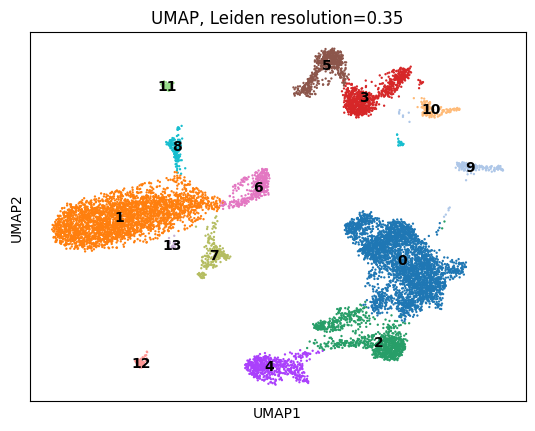

Markers found in dataset: 12 / 13


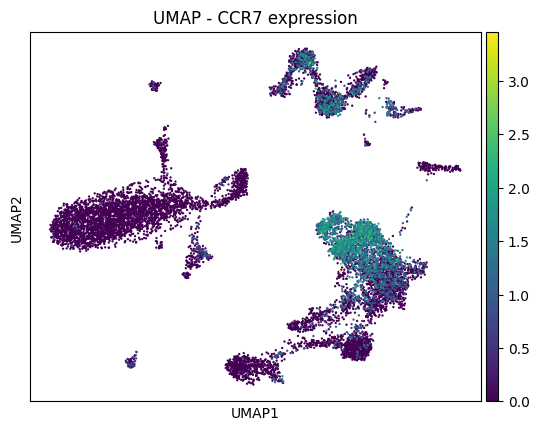

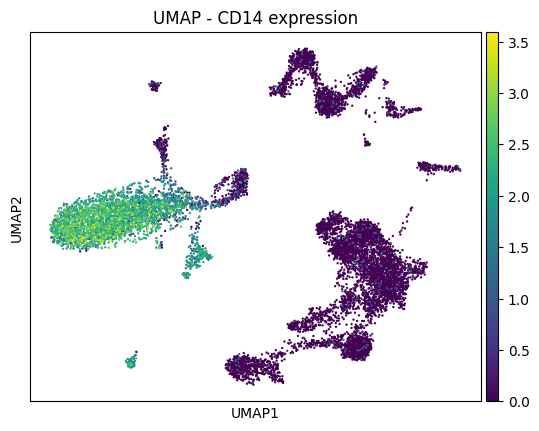

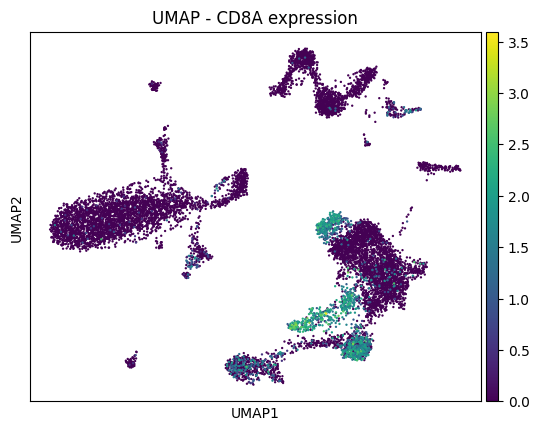

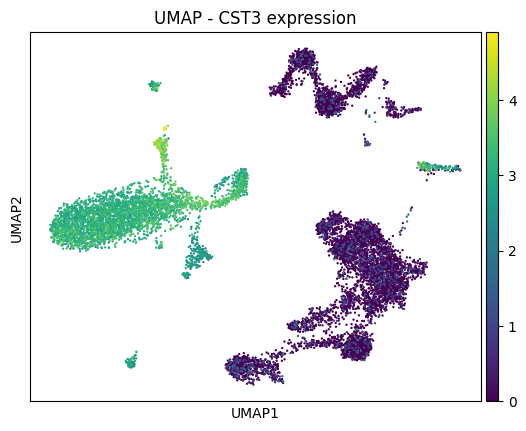

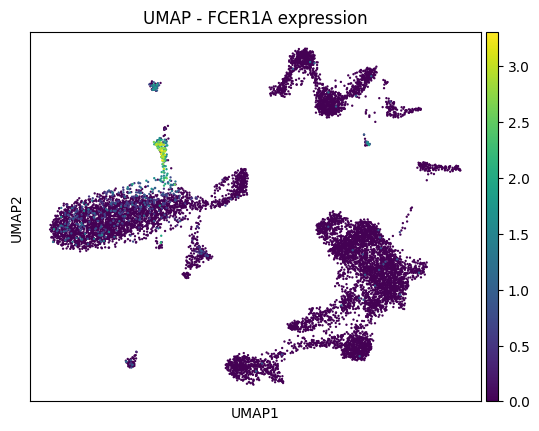

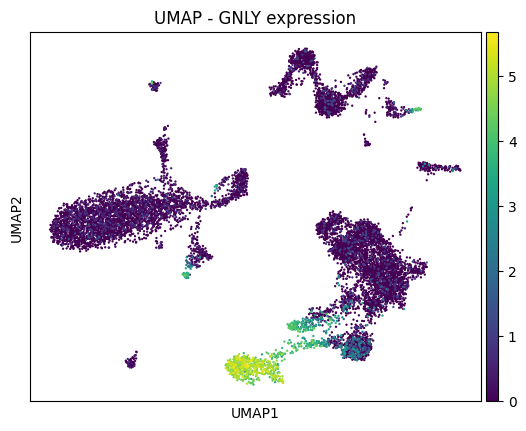

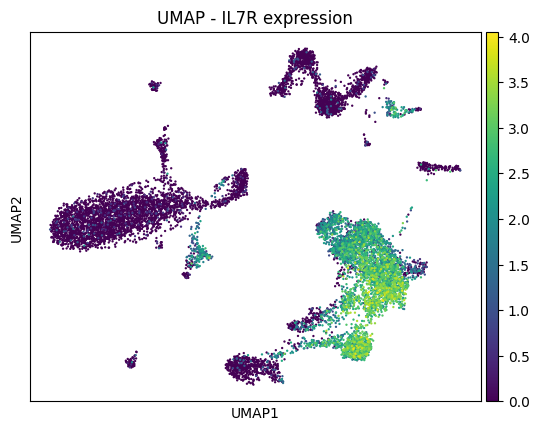

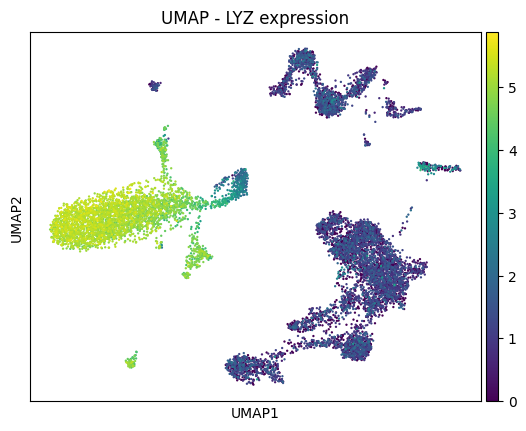

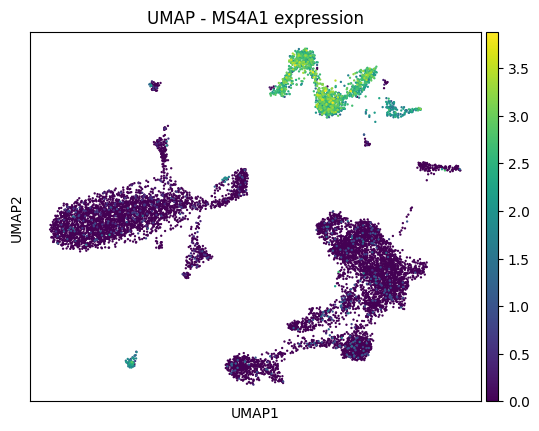

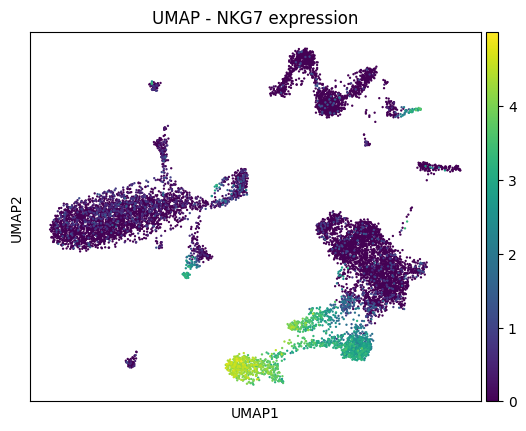

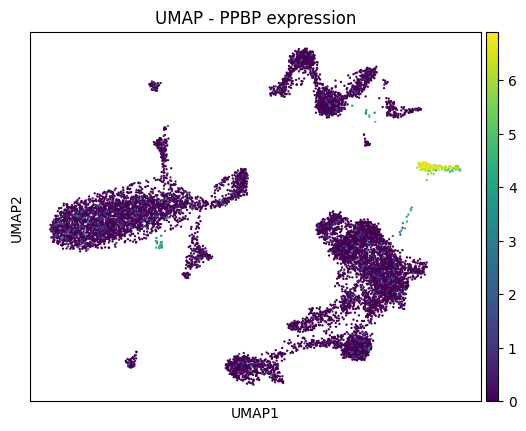

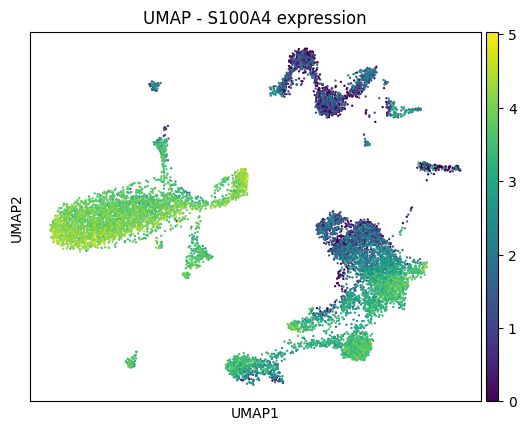

/tmp/ipykernel_36/4137391955.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  marker_expr = adata_eda[:, markers_in_data].to_df().groupby(adata_eda.obs['cluster']).mean()
/tmp/ipykernel_36/4137391955.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  marker_expr = adata_eda[:, markers_in_data].to_df().groupby(adata_eda.obs['cluster']).mean()
/tmp/ipykernel_36/4137391955.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this war


Assigned cell types by marker gene expression per cluster:
  Cluster 0: Memory CD4 T
  Cluster 1: Monocyte
  Cluster 10: B cell
  Cluster 11: Dendritic
  Cluster 12: Monocyte
  Cluster 13: Megakaryocyte
  Cluster 2: Memory CD4 T
  Cluster 3: B cell
  Cluster 4: NK
  Cluster 5: B cell
  Cluster 6: Memory CD4 T
  Cluster 7: Monocyte
  Cluster 8: Dendritic
  Cluster 9: Megakaryocyte


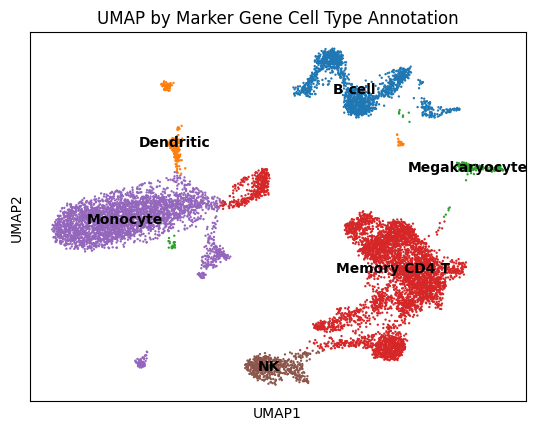

Leiden clustering and marker-based annotation saved.


In [36]:

adata_eda = sc.read("PBMC_eda_log_norm.h5ad")  

adata_eda.obs_names.name = 'cell_id'
adata_eda.var_names.name = 'gene_symbol'
adata_eda.var_names_make_unique()

print(f"Shape: {adata_eda.shape}")
print("First cells:", adata_eda.obs_names[:5])
print("First genes:", adata_eda.var_names[:5])

# PCA , neighbors & UMAP 
sc.tl.pca(adata_eda, svd_solver='arpack')
sc.pp.neighbors(adata_eda, n_pcs=50, n_neighbors=15)
sc.tl.umap(adata_eda)

# Searching for Leiden resolution giving ~14 clusters
target_n = 14
best_res = None
best_diff = 999
cluster_counts = {}

print("Trying Leiden resolutions 0.2 to 2.0 in steps of 0.05...")
for res in np.arange(0.2, 2.05, 0.05):
    sc.tl.leiden(adata_eda, resolution=res, key_added=f'leiden_{res:.2f}')
    n_clusters = adata_eda.obs[f'leiden_{res:.2f}'].nunique()
    cluster_counts[res] = n_clusters
    diff = abs(n_clusters - target_n)
    if diff < best_diff:
        best_diff = diff
        best_res = res
    print(f"Resolution: {res:.2f} --> {n_clusters} clusters")

print(f"\nBest resolution for ~{target_n} clusters: {best_res:.2f} ({cluster_counts[best_res]} clusters)")

#  Assigning chosen clusters 
best_leiden_key = f'leiden_{best_res:.2f}'
adata_eda.obs['cluster'] = adata_eda.obs[best_leiden_key]

# --- Step 4: UMAP plot ---
sc.pl.umap(
    adata_eda,
    color='cluster',
    legend_loc='on data',
    title=f"UMAP, Leiden resolution={best_res:.2f}"
)

# PBMC marker genes 
marker_dict = {
    "Naive CD4 T": ["IL7R", "CCR7"],
    "Memory CD4 T": ["IL7R", "S100A4"],
    "CD8 T": ["CD8A"],
    "NK": ["GNLY", "NKG7"],
    "B cell": ["MS4A1"],
    "Monocyte": ["CD14", "LYZ"],
    "Dendritic": ["FCER1A", "CST3"],
    "Megakaryocyte": ["PPBP"]
}

# Checking which markers exist
all_marker_genes = sorted(
    set(g for genes in marker_dict.values() for g in genes if g in adata_eda.var_names)
)
print(f"Markers found in dataset: {len(all_marker_genes)} / {sum(len(v) for v in marker_dict.values())}")

# Ploting each found marker
for gene in all_marker_genes:
    sc.pl.umap(adata_eda, color=gene, title=f"UMAP - {gene} expression", show=True)

# --- Step 6: Compute average marker expression per cluster ---
cluster_ids = sorted(adata_eda.obs['cluster'].unique())
cluster_marker_scores = pd.DataFrame(index=cluster_ids, columns=marker_dict.keys(), dtype=float)

for cell_type, markers in marker_dict.items():
    markers_in_data = [g for g in markers if g in adata_eda.var_names]
    if not markers_in_data:
        continue
    marker_expr = adata_eda[:, markers_in_data].to_df().groupby(adata_eda.obs['cluster']).mean()
    cluster_marker_scores.loc[marker_expr.index, cell_type] = marker_expr.mean(axis=1)

# Assign type with highest marker score
cluster2type = cluster_marker_scores.idxmax(axis=1).to_dict()
adata_eda.obs['cell_type_marker'] = adata_eda.obs['cluster'].map(cluster2type).astype('category')

print("\nAssigned cell types by marker gene expression per cluster:")
for c in cluster2type:
    print(f"  Cluster {c}: {cluster2type[c]}")

# UMAP with marker annotation 
sc.pl.umap(
    adata_eda,
    color='cell_type_marker',
    legend_loc='on data',
    title="UMAP by Marker Gene Cell Type Annotation"
)

# Save annotated data 
adata_eda.write("PBMC_eda_marker_annotated_9clusters.h5ad")
print("Leiden clustering and marker-based annotation saved.")


In [37]:
# Loading PBMC log-normalized data 
adata_eda = sc.read("PBMC_eda_log_norm.h5ad") 
adata_eda.obs_names.name = 'cell_id'
adata_eda.var_names.name = 'gene_symbol'
adata_eda.var_names_make_unique()

adata_raw = adata_eda.copy()

print(f" Loaded PBMC EDA: {adata_eda.shape}")
print("First cells:", adata_eda.obs_names[:3].tolist())
print("First genes:", adata_eda.var_names[:3].tolist())

#Ensuring HVGs (2000) exist for constraint set 
if "highly_variable" not in adata_eda.var.columns:
    sc.pp.highly_variable_genes(adata_eda, n_top_genes=2000, flavor="seurat")
adata_eda = adata_eda[:, adata_eda.var.highly_variable].copy()
print(f" HVG Subset Shape: {adata_eda.shape}")

#Checking for labels
label_key_candidates = ["label", "cell_type_marker", "cluster"]
label_key = next((k for k in label_key_candidates if k in adata_raw.obs.columns), None)

if label_key is None:
    # Making clusters on HVGs
    sc.tl.pca(adata_eda, svd_solver="arpack")
    sc.pp.neighbors(adata_eda, n_pcs=min(50, adata_eda.n_vars), n_neighbors=15)
    sc.tl.umap(adata_eda)
    sc.tl.leiden(adata_eda, resolution=1.0, key_added="cluster")

    # Copying cluster IDs to raw object
    adata_raw.obs["cluster"] = adata_eda.obs["cluster"].reindex(adata_raw.obs_names).values

    # Marker-based PBMC annotation 
    marker_dict = {
        "Naive CD4 T": ["IL7R", "CCR7"],
        "Memory CD4 T": ["IL7R", "S100A4"],
        "CD8 T": ["CD8A"],
        "NK": ["GNLY", "NKG7"],
        "B cell": ["MS4A1"],
        "Monocyte": ["CD14", "LYZ"],
        "Dendritic": ["FCER1A", "CST3"],
        "Megakaryocyte": ["PPBP"]
    }

    cluster_ids = sorted(adata_eda.obs['cluster'].unique())
    cluster_marker_scores = pd.DataFrame(index=cluster_ids, columns=marker_dict.keys(), dtype=float)

    for cell_type, markers in marker_dict.items():
        markers_in_data = [g for g in markers if g in adata_eda.var_names]
        if not markers_in_data:
            continue
        marker_expr = adata_eda[:, markers_in_data].to_df().groupby(adata_eda.obs['cluster']).mean()
        cluster_marker_scores.loc[marker_expr.index, cell_type] = marker_expr.mean(axis=1)

    if cluster_marker_scores.notna().any().any():
        cluster2type = cluster_marker_scores.idxmax(axis=1).to_dict()
        adata_eda.obs['cell_type_marker'] = adata_eda.obs['cluster'].map(cluster2type).astype('category')
        adata_raw.obs['cell_type_marker'] = adata_raw.obs['cluster'].map(cluster2type).astype('category')
        label_key = "cell_type_marker"
    else:
        label_key = "cluster"

print(f" Using labels from adata.obs['{label_key}']")

# Sanity check 
assert np.all(adata_raw.obs_names == adata_eda.obs_names), "Mismatch in cell IDs!"

# 80/10/10 split 
indices = np.arange(adata_raw.n_obs)
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)

# Creating subset AnnData objects 
adata_raw_train = adata_raw[train_idx].copy()
adata_raw_val   = adata_raw[val_idx].copy()
adata_raw_test  = adata_raw[test_idx].copy()

adata_eda_train = adata_eda[train_idx].copy()
adata_eda_val   = adata_eda[val_idx].copy()
adata_eda_test  = adata_eda[test_idx].copy()

# Attaching labels to splits 
cell_to_label = adata_raw.obs[label_key].astype(str)

for ad, name in zip([adata_raw_train, adata_raw_val, adata_raw_test], ["Train","Val","Test"]):
    ad.obs["label"] = cell_to_label.loc[ad.obs_names].values
    print(f" Labels attached to {name} RAW split. Missing:", ad.obs["label"].isna().sum())

for ad_hvg, name in zip([adata_eda_train, adata_eda_val, adata_eda_test], ["Train","Val","Test"]):
    ad_hvg.obs["label"] = cell_to_label.loc[ad_hvg.obs_names].values
    print(f" Labels attached to HVG {name} split. Missing:", ad_hvg.obs["label"].isna().sum())

#Printing summary 
print("\n=== Raw Splits ===")
print(f"Train: {adata_raw_train.shape}, {adata_raw_train.obs_names[:3].tolist()}")
print(f"Val:   {adata_raw_val.shape}, {adata_raw_val.obs_names[:3].tolist()}")
print(f"Test:  {adata_raw_test.shape}, {adata_raw_test.obs_names[:3].tolist()}")

print("\n=== HVG Splits ===")
print(f"Train: {adata_eda_train.shape}, {adata_eda_train.obs_names[:3].tolist()}")
print(f"Val:   {adata_eda_val.shape}, {adata_eda_val.obs_names[:3].tolist()}")
print(f"Test:  {adata_eda_test.shape}, {adata_eda_test.obs_names[:3].tolist()}")

# Saving all datasets 
adata_raw_train.write("pbmc_raw_train.h5ad")
adata_raw_val.write("pbmc_raw_val.h5ad")
adata_raw_test.write("pbmc_raw_test.h5ad")

adata_eda_train.write("pbmc_hvg_train.h5ad")
adata_eda_val.write("pbmc_hvg_val.h5ad")
adata_eda_test.write("pbmc_hvg_test.h5ad")

print("\n All PBMC splits saved with labels attached.")


 Loaded PBMC EDA: (10640, 20137)
First cells: ['AAACCCAAGCGCCCAT-1', 'AAACCCAAGGTTCCGC-1', 'AAACCCACAGAGTTGG-1']
First genes: ['AL627309.1', 'AL627309.3', 'AL669831.5']
 HVG Subset Shape: (10640, 2000)


/tmp/ipykernel_36/3575563374.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  marker_expr = adata_eda[:, markers_in_data].to_df().groupby(adata_eda.obs['cluster']).mean()
/tmp/ipykernel_36/3575563374.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  marker_expr = adata_eda[:, markers_in_data].to_df().groupby(adata_eda.obs['cluster']).mean()
/tmp/ipykernel_36/3575563374.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this war

 Using labels from adata.obs['cell_type_marker']


... storing 'label' as categorical


 Labels attached to Train RAW split. Missing: 0
 Labels attached to Val RAW split. Missing: 0
 Labels attached to Test RAW split. Missing: 0
 Labels attached to HVG Train split. Missing: 0
 Labels attached to HVG Val split. Missing: 0
 Labels attached to HVG Test split. Missing: 0

=== Raw Splits ===
Train: (8512, 20137), ['TTTGACTAGGCTTCCG-1', 'CGTTGGGTCATGCCAA-1', 'CGTAAGTAGTAACAGT-1']
Val:   (1064, 20137), ['TCGATTTTCACCTGTC-1', 'TTGCGTCGTCAAGCGA-1', 'CGAATTGGTTGGATCT-1']
Test:  (1064, 20137), ['AGGAAATTCATTTGCT-1', 'AGAGAGCAGACGCAGT-1', 'TCATGGACATATACCG-1']

=== HVG Splits ===
Train: (8512, 2000), ['TTTGACTAGGCTTCCG-1', 'CGTTGGGTCATGCCAA-1', 'CGTAAGTAGTAACAGT-1']
Val:   (1064, 2000), ['TCGATTTTCACCTGTC-1', 'TTGCGTCGTCAAGCGA-1', 'CGAATTGGTTGGATCT-1']
Test:  (1064, 2000), ['AGGAAATTCATTTGCT-1', 'AGAGAGCAGACGCAGT-1', 'TCATGGACATATACCG-1']


... storing 'label' as categorical
... storing 'label' as categorical
... storing 'label' as categorical
... storing 'label' as categorical
... storing 'label' as categorical



 All PBMC splits saved with labels attached.


In [38]:
# Loading labeled AnnData 
adata = sc.read("pbmc_hvg_train.h5ad")

# Checking for labels 
if 'label' not in adata.obs.columns:
    raise ValueError("adata.obs['label'] not found. Please attach true labels before running this.")

# Grouping cells by label
label_groups = adata.obs.groupby('label').groups  
 
user_input = input(" Enter TOTAL constraint sizes (comma-separated, e.g., 100,500,1000): ")
constraint_sizes = [int(x.strip()) for x in user_input.split(",") if x.strip().isdigit()]
print(f"\n Will generate constraints for TOTAL sizes: {constraint_sizes}")

def generate_constraints(label_groups, total_constraints, seed=42):
    random.seed(seed)
    labels = list(label_groups.keys())
    must_link = set()
    cannot_link = set()
    n_ml = total_constraints // 2 + total_constraints % 2  # if odd, must-link gets extra
    n_cl = total_constraints // 2

    # Must-link: pairs from same class
    while len(must_link) < n_ml:
        label = random.choice(labels)
        members = list(label_groups[label])
        if len(members) >= 2:
            pair = tuple(sorted(random.sample(members, 2)))
            must_link.add(pair)

    # Cannot-link: pairs from different classes
    while len(cannot_link) < n_cl:
        l1, l2 = random.sample(labels, 2)
        if l1 == l2:
            continue
        i = random.choice(label_groups[l1])
        j = random.choice(label_groups[l2])
        pair = tuple(sorted((i, j)))
        if pair not in must_link:  # Don't allow overlap
            cannot_link.add(pair)

    return list(must_link), list(cannot_link)

# === Generate and store constraints in-memory ===
constraints = {}

for total_size in constraint_sizes:
    ml, cl = generate_constraints(label_groups, total_constraints=total_size)
    constraints[total_size] = {
        "must_link": ml,
        "cannot_link": cl
    }
    print(f"\n Constraints generated for total size {total_size}:")
    print(f"   ↪ Must-link pairs:    {len(ml)}")
    print(f"   ↪ Cannot-link pairs:  {len(cl)}")


/tmp/ipykernel_36/1277410567.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  label_groups = adata.obs.groupby('label').groups


 Enter TOTAL constraint sizes (comma-separated, e.g., 100,500,1000):  0,1000,2000,3000,4000,5000,6000



 Will generate constraints for TOTAL sizes: [0, 1000, 2000, 3000, 4000, 5000, 6000]

 Constraints generated for total size 0:
   ↪ Must-link pairs:    0
   ↪ Cannot-link pairs:  0

 Constraints generated for total size 1000:
   ↪ Must-link pairs:    500
   ↪ Cannot-link pairs:  500

 Constraints generated for total size 2000:
   ↪ Must-link pairs:    1000
   ↪ Cannot-link pairs:  1000

 Constraints generated for total size 3000:
   ↪ Must-link pairs:    1500
   ↪ Cannot-link pairs:  1500

 Constraints generated for total size 4000:
   ↪ Must-link pairs:    2000
   ↪ Cannot-link pairs:  2000

 Constraints generated for total size 5000:
   ↪ Must-link pairs:    2500
   ↪ Cannot-link pairs:  2500

 Constraints generated for total size 6000:
   ↪ Must-link pairs:    3000
   ↪ Cannot-link pairs:  3000


Integer label mapping (for metrics):
0: Memory CD4 T
1: Monocyte
2: B cell
3: NK
4: Dendritic
5: Megakaryocyte
 KMeans Baseline Evaluation
 ARI: 0.8293
 NMI: 0.8140
 CA:  0.9070


... storing 'true_label' as categorical
... storing 'kmeans_pred' as categorical



 PCA & UMAP of KMeans Predictions


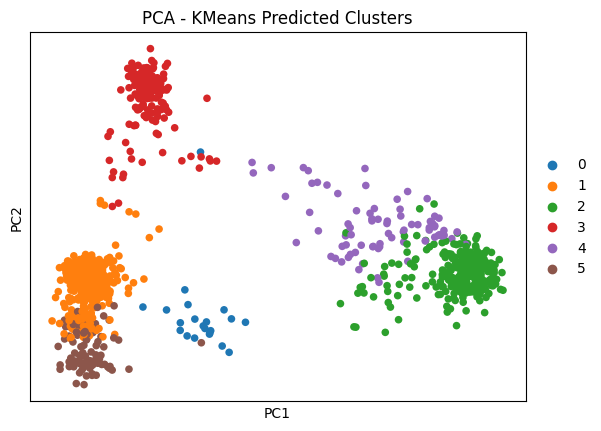

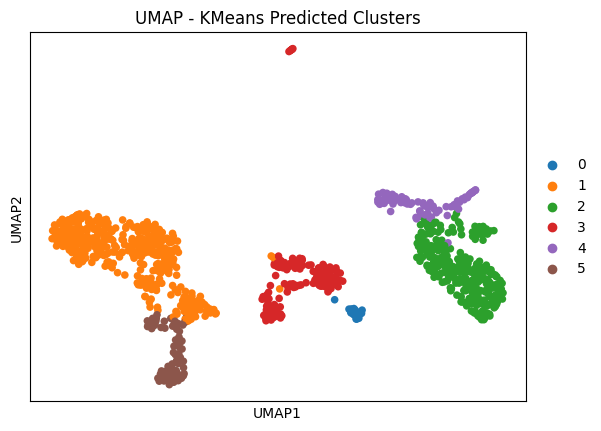

In [39]:
#Loading HVG log-normalized training and test data 
adata_train = sc.read("pbmc_hvg_train.h5ad")
adata_test = sc.read("pbmc_hvg_test.h5ad")  

# Extracting matrices and true labels
X_train = adata_train.X
X_test = adata_test.X

# Using all cell types 
true_labels, unique_types = pd.factorize(adata_test.obs["label"].astype(str).values)
n_clusters = len(np.unique(true_labels))


print("Integer label mapping (for metrics):")
for i, name in enumerate(unique_types):
    print(f"{i}: {name}")

# Training KMeans on training set 
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X_train)

#Predicting test labels 
pred_labels = kmeans.predict(X_test)

# Clustering Accuracy using Hungarian matching 
def clustering_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    return cm[row_ind, col_ind].sum() / y_true.size

# Computing Metrics 
ari_kmeans = adjusted_rand_score(true_labels, pred_labels)
nmi_kmeans = normalized_mutual_info_score(true_labels, pred_labels)
ca_kmeans = clustering_accuracy(true_labels, pred_labels)

#Saving results 
kmeans_results = {
    "ARI": ari_kmeans,
    "NMI": nmi_kmeans,
    "CA": ca_kmeans,
    "true_labels": true_labels,
    "pred_labels": pred_labels
}

#  Printing metrics 
print(" KMeans Baseline Evaluation")
print(f" ARI: {ari_kmeans:.4f}")
print(f" NMI: {nmi_kmeans:.4f}")
print(f" CA:  {ca_kmeans:.4f}")

#Preparing for visualization 
adata_vis = adata_test.copy()
# If you used the 'Unknown' mask, do: adata_vis = adata_vis[mask].copy()
adata_vis.obs["true_label"] = pd.Series(true_labels, index=adata_vis.obs_names).astype(str)
adata_vis.obs["kmeans_pred"] = pd.Series(pred_labels, index=adata_vis.obs_names).astype(str)

# Dimensionality Reduction 
sc.pp.pca(adata_vis, n_comps=19)
sc.pp.neighbors(adata_vis)
sc.tl.umap(adata_vis)

# Visualizing only predicted KMeans clusters 
print("\n PCA & UMAP of KMeans Predictions")
sc.pl.pca(
    adata_vis,
    color="kmeans_pred",
    title="PCA - KMeans Predicted Clusters",
    size=120,
    show=True
)

sc.pl.umap(
    adata_vis,
    color="kmeans_pred",
    title="UMAP - KMeans Predicted Clusters",
    size=120,
    show=True
)


Integer label mapping (for metrics):
0: Memory CD4 T
1: Monocyte
2: B cell
3: NK
4: Dendritic
5: Megakaryocyte
Training shape: (8512, 2000), Test shape: (1064, 2000), Clusters: 6
 Pretraining Autoencoder...
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.1737
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0869
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0624
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0590
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0577
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0569
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0564
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0552
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0546
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0541
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0541
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0530
Epoch 13/

... storing 'dec_pred' as categorical


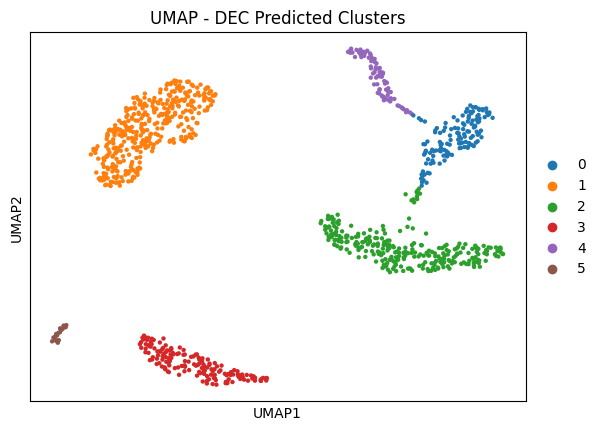

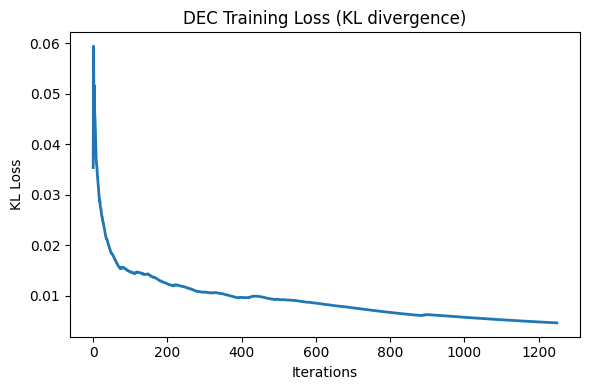

In [40]:
# Loading Data
adata_train = sc.read("pbmc_hvg_train.h5ad")
adata_test = sc.read("pbmc_hvg_test.h5ad") 


X_train = adata_train.X.astype(np.float32)
X_test = adata_test.X.astype(np.float32)
true_labels, unique_types = pd.factorize(adata_test.obs["label"].astype(str).values)
n_clusters = len(np.unique(true_labels))

print("Integer label mapping (for metrics):")
for i, name in enumerate(unique_types):
    print(f"{i}: {name}")

print(f"Training shape: {X_train.shape}, Test shape: {X_test.shape}, Clusters: {n_clusters}")

# Clustering Accuracy 
def clustering_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    return cm[row_ind, col_ind].sum() / y_true.size

# Autoencoder Definition & Pretrain 
input_dim = X_train.shape[1]
encoding_dim = 10

input_layer = Input(shape=(input_dim,))
encoded = Dense(500, activation='relu')(input_layer)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
latent = Dense(encoding_dim, name='latent')(encoded)

decoded = Dense(2000, activation='relu')(latent)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
encoder = Model(inputs=input_layer, outputs=latent)

autoencoder.compile(optimizer='adam', loss='mse')
print(" Pretraining Autoencoder...")
autoencoder.fit(X_train, X_train, batch_size=256, epochs=50, verbose=1)

# KMeans Init 
Z_train = encoder.predict(X_train)
Z_test = encoder.predict(X_test)
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
kmeans.fit(Z_train)
cluster_centers = kmeans.cluster_centers_

#  Clustering Layer 
class ClusteringLayer(tf.keras.layers.Layer):
    def __init__(self, n_clusters, initial_weights=None, **kwargs):
        super().__init__(**kwargs)
        self.n_clusters = n_clusters
        self.initial_weights = initial_weights

    def build(self, input_shape):
        input_dim = input_shape[1]
        self.clusters = self.add_weight(
            shape=(self.n_clusters, input_dim),
            initializer='glorot_uniform',
            name='clusters'
        )
        if self.initial_weights is not None:
            self.set_weights([self.initial_weights.astype(np.float32)])
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        # Student’s t-distribution
        q = 1.0 / (1.0 + (tf.reduce_sum(tf.square(tf.expand_dims(inputs, axis=1) - self.clusters), axis=2)))
        q = q ** ((self.n_clusters + 1.0) / 2.0)
        q_sum = tf.reduce_sum(q, axis=1, keepdims=True)
        q = q / (q_sum + 1e-8)  # Protects against division by zero
        q = tf.clip_by_value(q, 1e-8, 1.0)
        return q

# Targeting Distribution 
def target_distribution(q, eps=1e-8):
    q = np.clip(q, eps, 1.0)
    weight = q ** 2 / (np.sum(q, axis=0, keepdims=True) + eps)
    p = (weight.T / (np.sum(weight, axis=1) + eps)).T
    return p

#  Building DEC Model 
clustering_layer = ClusteringLayer(n_clusters, initial_weights=cluster_centers, name='clustering')(encoder.output)
dec_model = Model(inputs=encoder.input, outputs=clustering_layer)
dec_model.compile(optimizer='adam', loss='kld')

# KL Fine-tuning 
print(" Fine-tuning DEC with KL divergence...")
maxiter = 5000
update_interval = 50
tol = 1e-4
min_kl_updates = 2  # Stop after 2 consecutive below-tol
kl_no_change = 0
batch_size = 256
loss_history = []
index_array = np.arange(X_train.shape[0])

q = dec_model.predict(X_train, verbose=0)
assert np.isfinite(q).all(), "NaNs in initial q!"
p = target_distribution(q)
assert np.isfinite(p).all(), "NaNs in initial p!"
y_pred_last = q.argmax(1)

for ite in range(maxiter):
    if ite % update_interval == 0:
        q = dec_model.predict(X_train, verbose=0)
        if not np.isfinite(q).all():
            print(f"NaNs detected in q at iter {ite}")
            print("q stats: min", np.nanmin(q), "max", np.nanmax(q))
            break
        p = target_distribution(q)
        if not np.isfinite(p).all():
            print(f"NaNs detected in p at iter {ite}")
            print("p stats: min", np.nanmin(p), "max", np.nanmax(p))
            break
        y_pred = q.argmax(1)
        label_change_rate = np.mean(y_pred != y_pred_last)
        print(f"Iter {ite}, Label change rate: {label_change_rate:.5f}")
        if label_change_rate < tol:
            kl_no_change += 1
            if kl_no_change >= min_kl_updates:
                print(f"Converged (label change rate < tol for {min_kl_updates} consecutive intervals).")
                break
        else:
            kl_no_change = 0
        y_pred_last = y_pred
    # Batch update
    idx = np.random.choice(index_array, batch_size, replace=False)
    loss = dec_model.train_on_batch(X_train[idx], p[idx])
    loss_history.append(float(loss))

#  Evaluating on Test Set 
q_test = dec_model.predict(X_test)
pred_labels = q_test.argmax(1)
ari = adjusted_rand_score(true_labels, pred_labels)
nmi = normalized_mutual_info_score(true_labels, pred_labels)
ca = clustering_accuracy(true_labels, pred_labels)

print("\n🎯 DEC (with KL fine-tuning) Evaluation")
print(f" ARI: {ari:.4f}")
print(f" NMI: {nmi:.4f}")
print(f" CA:  {ca:.4f}")

# Saving results 
dec_results = {
    "ARI": ari,
    "NMI": nmi,
    "CA": ca,
    "true_labels": true_labels,
    "pred_labels": pred_labels,
    "kl_loss_history": loss_history,
}

# UMAP Visualization 
adata_vis = adata_test.copy()
adata_vis.obsm["X_latent"] = encoder.predict(X_test)
adata_vis.obs["dec_pred"] = pd.Series(pred_labels, index=adata_vis.obs_names).astype(str)
sc.pp.neighbors(adata_vis, use_rep="X_latent")
sc.tl.umap(adata_vis)
sc.pl.umap(adata_vis, color="dec_pred", title="UMAP - DEC Predicted Clusters", size=40)

#KL Loss Curve
plt.figure(figsize=(6, 4))
plt.plot(loss_history, lw=2)
plt.title("DEC Training Loss (KL divergence)")
plt.xlabel("Iterations")
plt.ylabel("KL Loss")
plt.tight_layout()
plt.show()


In [46]:

# DEVICE SETUP

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# UTILS
def clustering_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    return cm[row_ind, col_ind].sum() / y_true.size

class IndexedTensorDataset(TensorDataset):
    def __getitem__(self, idx):
        data = super().__getitem__(idx)
        return (*data, idx)

def get_in_batch_pairs(batch_indices, constraint_pairs):
    batch_map = {idx: i for i, idx in enumerate(batch_indices)}
    pairs_in_batch = [
        (batch_map[i], batch_map[j])
        for i, j in constraint_pairs if i in batch_map and j in batch_map
    ]
    return pairs_in_batch

def contrastive_loss(z, must_link, cannot_link, margin=2.0, alpha=10.0, beta=50.0):
    loss_ml = 0.0
    loss_cl = 0.0
    eps = 1e-9
    if len(must_link) > 0:
        for i, j in must_link:
            dist = torch.norm(z[i] - z[j], p=2)
            loss_ml += dist ** 2
        loss_ml = loss_ml / (len(must_link) + eps)
    if len(cannot_link) > 0:
        for i, j in cannot_link:
            dist = torch.norm(z[i] - z[j], p=2)
            loss_cl += F.relu(margin - dist) ** 2
        loss_cl = loss_cl / (len(cannot_link) + eps)
    return alpha * loss_ml + beta * loss_cl

class ZINBLoss(nn.Module):
    def __init__(self, ridge_lambda=0.0):
        super(ZINBLoss, self).__init__()
        self.eps = 1e-10
        self.ridge_lambda = ridge_lambda
    def forward(self, x, pi, theta, mu):
        theta = torch.clamp(theta, min=self.eps)
        pi = torch.clamp(pi, min=self.eps, max=1.0 - self.eps)
        mu = torch.clamp(mu, min=self.eps)
        t1 = torch.lgamma(theta + self.eps) + torch.lgamma(x + 1.0) - torch.lgamma(x + theta + self.eps)
        t2 = (theta + x) * torch.log(1.0 + (mu / theta)) + x * (torch.log(theta + self.eps) - torch.log(mu + self.eps))
        nb_case = t1 + t2 - torch.log(1.0 - pi + self.eps)
        zero_case = -torch.log(pi + ((1.0 - pi) * torch.pow(theta / (theta + mu), theta)) + self.eps)
        result = torch.where(torch.lt(x, 1e-8), zero_case, nb_case)
        ridge = self.ridge_lambda * torch.sum(torch.square(pi))
        return torch.mean(result) + ridge

# scDCC Network
class scDCC(nn.Module):
    def __init__(self, input_dim, latent_dim=20):
        super(scDCC, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )
        self.pi_layer = nn.Linear(latent_dim, input_dim)
        self.theta_layer = nn.Parameter(torch.randn(input_dim))

    def forward(self, x):
        z = self.encoder(x)
        # Debug: check for NaNs/Infs in z
        if not torch.isfinite(z).all():
            print(" NaNs/Infs detected in latent z (forward)")
            print("z min/max:", z.min().item(), z.max().item())
            print(z)
            assert torch.isfinite(z).all()
        dec = self.decoder(z)
        dec = torch.clamp(dec, min=-10, max=10)  # CLAMP TO PREVENT OVERFLOW
        pi = torch.sigmoid(self.pi_layer(z))
        theta = F.softplus(self.theta_layer)
        mu = torch.exp(dec)
        for name, tensor in zip(["pi", "theta", "mu"], [pi, theta, mu]):
            if not torch.isfinite(tensor).all():
                print(f" NaNs/Infs in {name} (forward)")
                print(f"{name} min/max:", tensor.min().item(), tensor.max().item())
                print(tensor)
                assert torch.isfinite(tensor).all()
        return pi, theta, mu, z


# Pretraining 
def pretrain_autoencoder(model, X_train, X_val, train_labels, val_labels,
                         epochs=25, batch_size=256, lr=1e-3, print_every=None):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = ZINBLoss()

    X_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32, device=device)

    loader = DataLoader(TensorDataset(X_tensor), batch_size=batch_size, shuffle=True)

    if print_every is None:
        print_every = max(1, epochs // 5)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in loader:
            x = batch[0].to(device)
            pi, theta, mu, _ = model(x)
            loss = loss_fn(x, pi, theta, mu)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if (epoch + 1) % print_every == 0 or epoch == 0 or (epoch + 1) == epochs:
            # Evaluate clustering metrics on train and val (latent -> KMeans)
            model.eval()
            with torch.no_grad():
                _, _, _, z_train = model(X_tensor)
                _, _, _, z_val = model(X_val_tensor)
            kmeans = KMeans(n_clusters=len(np.unique(train_labels)), random_state=42).fit(z_train.cpu().numpy())
            pred_train = kmeans.predict(z_train.cpu().numpy())
            pred_val = kmeans.predict(z_val.cpu().numpy())
            ari_train = adjusted_rand_score(train_labels, pred_train)
            ari_val = adjusted_rand_score(val_labels, pred_val)
            print(f"  [Pretrain] Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(loader):.4f} | "
                  f"ARI-train: {ari_train:.3f} | ARI-val: {ari_val:.3f}")


# Training With Constraints
def train_scdcc(model, X_train, X_val, must_link, cannot_link, train_labels, val_labels,
                epochs=25, batch_size=256, lr=1e-3, print_every=None,
                alpha=1.0, beta=5.0, margin=2.0):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    zinb_loss_fn = ZINBLoss()

    X_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32, device=device)

    dataset = IndexedTensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    num_batches = int(np.ceil(X_tensor.shape[0] / batch_size))
    loss_curve = []

    if print_every is None:
        print_every = max(1, epochs // 5)

    for epoch in range(epochs):
        epoch_loss = 0
        for batch in loader:
            x = batch[0].to(device)
            batch_indices = batch[1].cpu().numpy()
            ml_in = get_in_batch_pairs(batch_indices, must_link)
            cl_in = get_in_batch_pairs(batch_indices, cannot_link)

            pi, theta, mu, z = model(x)
            constr_loss = contrastive_loss(z, ml_in, cl_in, margin=margin, alpha=alpha, beta=beta)
            zinb_loss = zinb_loss_fn(x, pi, theta, mu)
            loss = zinb_loss + constr_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        loss_curve.append(epoch_loss / num_batches)

        if (epoch + 1) % print_every == 0 or epoch == 0 or (epoch + 1) == epochs:
            model.eval()
            with torch.no_grad():
                _, _, _, z_train = model(X_tensor)
                _, _, _, z_val = model(X_val_tensor)
            kmeans = KMeans(n_clusters=len(np.unique(train_labels)), random_state=42).fit(z_train.cpu().numpy())
            pred_train = kmeans.predict(z_train.cpu().numpy())
            pred_val = kmeans.predict(z_val.cpu().numpy())
            ari_train = adjusted_rand_score(train_labels, pred_train)
            ari_val = adjusted_rand_score(val_labels, pred_val)
            print(f"  [Fine-tune] Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/num_batches:.4f} | "
                  f"ARI-train: {ari_train:.3f} | ARI-val: {ari_val:.3f}")
    return loss_curve


# SCDCC Pipeline
def run_full_scdcc_pipeline(
    X_train, X_val, X_test, train_labels, val_labels, test_labels, constraints_idx,
    latent_dims=[10, 20, 50], lrs=[1e-3, 5e-4],
    pretrain_epochs=25, train_epochs=25, n_repeats=10,
    alpha=1.0, beta=5.0, margin=2.0, tune_constraint_index=0
):
    """
    Runs with ~50 total epochs per run (25 pretrain + 25 fine-tune) by default.
    The hyperparameter search stage uses half of these (pretrain_epochs//2 and train_epochs//2).
    """
    final_results = {}
    constraint_sizes = sorted(list(constraints_idx.keys()))

    #  Hyperparameter search on chosen constraint set 
    hp_size = constraint_sizes[tune_constraint_index]
    must_link_hp = constraints_idx[hp_size]['must_link']
    cannot_link_hp = constraints_idx[hp_size]['cannot_link']
    print(f"\n Hyperparameter search on constraint size: {hp_size}")

    best_config = None
    best_ari = -1

    for latent_dim, lr in itertools.product(latent_dims, lrs):
        print(f"  Trying latent_dim={latent_dim}, lr={lr}")
        model = scDCC(input_dim=X_train.shape[1], latent_dim=latent_dim).to(device)

        # Half-epochs during HP search to save time
        hp_pre_epochs = max(1, pretrain_epochs // 2)
        hp_train_epochs = max(1, train_epochs // 2)

        pretrain_autoencoder(
            model, X_train, X_val, train_labels, val_labels,
            epochs=hp_pre_epochs, lr=lr, print_every=max(1, hp_pre_epochs // 5)
        )
        train_scdcc(
            model, X_train, X_val, must_link_hp, cannot_link_hp, train_labels, val_labels,
            epochs=hp_train_epochs, lr=lr, print_every=max(1, hp_train_epochs // 5),
            alpha=alpha, beta=beta, margin=margin
        )

        model.eval()
        with torch.no_grad():
            _, _, _, z_val = model(torch.tensor(X_val, dtype=torch.float32, device=device))
        pred_val = KMeans(n_clusters=len(np.unique(val_labels)), random_state=42).fit_predict(z_val.cpu().numpy())
        ari_val = adjusted_rand_score(val_labels, pred_val)
        print(f"     ➡ ARI-val: {ari_val:.4f}")
        if ari_val > best_ari:
            best_ari = ari_val
            best_config = (latent_dim, lr)

    print(f"\n Best config (latent_dim={best_config[0]}, lr={best_config[1]}) from constraint size {hp_size}.")

    #  Running all constraint sizes with the best config, N times 
    for size in constraint_sizes:
        print(f"\n=== SCDCC with constraint size: {size} ===")
        must_link = constraints_idx[size]['must_link']
        cannot_link = constraints_idx[size]['cannot_link']

        all_ari, all_nmi, all_ca = [], [], []
        z_tests = []
        pred_tests = []
        loss_curves = []

        for run in range(n_repeats):
            print(f"   Run {run+1}/{n_repeats}")
            model = scDCC(input_dim=X_train.shape[1], latent_dim=best_config[0]).to(device)

            pretrain_autoencoder(
                model, X_train, X_val, train_labels, val_labels,
                epochs=pretrain_epochs, lr=best_config[1], print_every=max(1, pretrain_epochs // 5)
            )
            loss_curve = train_scdcc(
                model, X_train, X_val, must_link, cannot_link, train_labels, val_labels,
                epochs=train_epochs, lr=best_config[1], print_every=max(1, train_epochs // 5),
                alpha=alpha, beta=beta, margin=margin
            )

            model.eval()
            with torch.no_grad():
                _, _, _, z_test = model(torch.tensor(X_test, dtype=torch.float32, device=device))

            z_test = z_test.cpu().numpy()
            pred_labels = KMeans(n_clusters=len(np.unique(test_labels)), random_state=run).fit_predict(z_test)

            z_tests.append(z_test)
            pred_tests.append(pred_labels)
            loss_curves.append(loss_curve)

            ari = adjusted_rand_score(test_labels, pred_labels)
            nmi = normalized_mutual_info_score(test_labels, pred_labels)
            ca = clustering_accuracy(test_labels, pred_labels)
            print(f"     ARI: {ari:.4f}, NMI: {nmi:.4f}, CA: {ca:.4f}")

            all_ari.append(ari)
            all_nmi.append(nmi)
            all_ca.append(ca)

        print(f"\n Results for constraint size {size}:")
        print(f"   ARI: {np.mean(all_ari):.4f} ± {np.std(all_ari):.4f}")
        print(f"   NMI: {np.mean(all_nmi):.4f} ± {np.std(all_nmi):.4f}")
        print(f"   CA : {np.mean(all_ca):.4f} ± {np.std(all_ca):.4f}")

        final_results[size] = {
            "ARI_mean": float(np.mean(all_ari)), "ARI_std": float(np.std(all_ari)),
            "NMI_mean": float(np.mean(all_nmi)), "NMI_std": float(np.std(all_nmi)),
            "CA_mean": float(np.mean(all_ca)), "CA_std": float(np.std(all_ca)),
            "z_tests": z_tests,          # list of arrays
            "test_preds": pred_tests,    # list of arrays
            "loss_curves": loss_curves   # list of lists
        }

    return final_results



Using device: cuda


Integer label mapping (use class_names[i] to get the cell type):
0: Memory CD4 T
1: Monocyte
2: Dendritic
3: NK
4: B cell
5: Megakaryocyte

 Hyperparameter search on constraint size: 3000
  Trying latent_dim=10, lr=0.001


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/25, Loss: 0.3463 | ARI-train: 0.557 | ARI-val: 0.525


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 5/25, Loss: 0.2670 | ARI-train: 0.326 | ARI-val: 0.349


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/25, Loss: 0.2622 | ARI-train: 0.264 | ARI-val: 0.288


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 15/25, Loss: 0.2590 | ARI-train: 0.249 | ARI-val: 0.280


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/25, Loss: 0.2562 | ARI-train: 0.243 | ARI-val: 0.278


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 25/25, Loss: 0.2534 | ARI-train: 0.235 | ARI-val: 0.270


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/25, Loss: 11.7810 | ARI-train: 0.427 | ARI-val: 0.455


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 5/25, Loss: 3.2857 | ARI-train: 0.601 | ARI-val: 0.629


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/25, Loss: 1.6917 | ARI-train: 0.689 | ARI-val: 0.715


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/25, Loss: 1.0257 | ARI-train: 0.815 | ARI-val: 0.819


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/25, Loss: 0.9061 | ARI-train: 0.824 | ARI-val: 0.832


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 25/25, Loss: 0.7205 | ARI-train: 0.670 | ARI-val: 0.659
     ➡ ARI-val: 0.6606
  Trying latent_dim=10, lr=0.0005


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/25, Loss: 0.3712 | ARI-train: 0.654 | ARI-val: 0.642


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 5/25, Loss: 0.2782 | ARI-train: 0.405 | ARI-val: 0.421


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/25, Loss: 0.2660 | ARI-train: 0.278 | ARI-val: 0.309


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 15/25, Loss: 0.2636 | ARI-train: 0.242 | ARI-val: 0.274


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/25, Loss: 0.2615 | ARI-train: 0.242 | ARI-val: 0.287


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 25/25, Loss: 0.2596 | ARI-train: 0.216 | ARI-val: 0.230


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/25, Loss: 16.0683 | ARI-train: 0.459 | ARI-val: 0.458


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 5/25, Loss: 1.0097 | ARI-train: 0.592 | ARI-val: 0.567


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/25, Loss: 1.7587 | ARI-train: 0.614 | ARI-val: 0.599


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/25, Loss: 1.0493 | ARI-train: 0.807 | ARI-val: 0.818


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/25, Loss: 0.7517 | ARI-train: 0.842 | ARI-val: 0.846


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 25/25, Loss: 0.6563 | ARI-train: 0.917 | ARI-val: 0.907
     ➡ ARI-val: 0.9068
  Trying latent_dim=20, lr=0.001


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/25, Loss: 0.3421 | ARI-train: 0.631 | ARI-val: 0.641


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 5/25, Loss: 0.2654 | ARI-train: 0.305 | ARI-val: 0.306


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/25, Loss: 0.2614 | ARI-train: 0.286 | ARI-val: 0.297


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 15/25, Loss: 0.2581 | ARI-train: 0.284 | ARI-val: 0.304


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/25, Loss: 0.2551 | ARI-train: 0.266 | ARI-val: 0.284


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 25/25, Loss: 0.2523 | ARI-train: 0.262 | ARI-val: 0.277


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/25, Loss: 12.9294 | ARI-train: 0.521 | ARI-val: 0.526


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 5/25, Loss: 2.4300 | ARI-train: 0.592 | ARI-val: 0.565


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/25, Loss: 2.1055 | ARI-train: 0.660 | ARI-val: 0.637


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/25, Loss: 1.0022 | ARI-train: 0.665 | ARI-val: 0.639


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/25, Loss: 1.3959 | ARI-train: 0.697 | ARI-val: 0.665


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 25/25, Loss: 0.7921 | ARI-train: 0.854 | ARI-val: 0.851
     ➡ ARI-val: 0.8231
  Trying latent_dim=20, lr=0.0005


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/25, Loss: 0.3696 | ARI-train: 0.642 | ARI-val: 0.634


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 5/25, Loss: 0.2699 | ARI-train: 0.330 | ARI-val: 0.329


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/25, Loss: 0.2650 | ARI-train: 0.255 | ARI-val: 0.258


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 15/25, Loss: 0.2629 | ARI-train: 0.253 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/25, Loss: 0.2610 | ARI-train: 0.265 | ARI-val: 0.275


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 25/25, Loss: 0.2592 | ARI-train: 0.264 | ARI-val: 0.271


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/25, Loss: 35.0827 | ARI-train: 0.406 | ARI-val: 0.423


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 5/25, Loss: 3.9114 | ARI-train: 0.664 | ARI-val: 0.696


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/25, Loss: 2.2899 | ARI-train: 0.643 | ARI-val: 0.672


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/25, Loss: 0.6017 | ARI-train: 0.841 | ARI-val: 0.834


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/25, Loss: 1.1281 | ARI-train: 0.643 | ARI-val: 0.626


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 25/25, Loss: 1.2530 | ARI-train: 0.852 | ARI-val: 0.854
     ➡ ARI-val: 0.8375
  Trying latent_dim=50, lr=0.001


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/25, Loss: 0.3340 | ARI-train: 0.681 | ARI-val: 0.709


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 5/25, Loss: 0.2672 | ARI-train: 0.375 | ARI-val: 0.382


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/25, Loss: 0.2630 | ARI-train: 0.308 | ARI-val: 0.318


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 15/25, Loss: 0.2594 | ARI-train: 0.305 | ARI-val: 0.316


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/25, Loss: 0.2562 | ARI-train: 0.296 | ARI-val: 0.297


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 25/25, Loss: 0.2530 | ARI-train: 0.303 | ARI-val: 0.304


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/25, Loss: 40.1248 | ARI-train: 0.479 | ARI-val: 0.461


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 5/25, Loss: 1.4821 | ARI-train: 0.829 | ARI-val: 0.832


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/25, Loss: 1.0058 | ARI-train: 0.779 | ARI-val: 0.778


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/25, Loss: 1.3003 | ARI-train: 0.693 | ARI-val: 0.670


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/25, Loss: 2.9539 | ARI-train: 0.537 | ARI-val: 0.530


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 25/25, Loss: 1.0256 | ARI-train: 0.800 | ARI-val: 0.808
     ➡ ARI-val: 0.6726
  Trying latent_dim=50, lr=0.0005


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/25, Loss: 0.3641 | ARI-train: 0.625 | ARI-val: 0.601


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 5/25, Loss: 0.2688 | ARI-train: 0.428 | ARI-val: 0.441


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/25, Loss: 0.2654 | ARI-train: 0.340 | ARI-val: 0.343


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 15/25, Loss: 0.2630 | ARI-train: 0.330 | ARI-val: 0.341


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/25, Loss: 0.2609 | ARI-train: 0.325 | ARI-val: 0.332


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 25/25, Loss: 0.2589 | ARI-train: 0.323 | ARI-val: 0.329


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/25, Loss: 25.4993 | ARI-train: 0.641 | ARI-val: 0.635


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 5/25, Loss: 2.7801 | ARI-train: 0.584 | ARI-val: 0.561


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/25, Loss: 1.7809 | ARI-train: 0.804 | ARI-val: 0.802


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 15/25, Loss: 2.0811 | ARI-train: 0.834 | ARI-val: 0.852


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/25, Loss: 1.7974 | ARI-train: 0.634 | ARI-val: 0.604


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 25/25, Loss: 0.5669 | ARI-train: 0.803 | ARI-val: 0.794
     ➡ ARI-val: 0.7818

 Best config (latent_dim=10, lr=0.0005) from constraint size 3000.

=== SCDCC with constraint size: 0 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3718 | ARI-train: 0.653 | ARI-val: 0.645


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2665 | ARI-train: 0.289 | ARI-val: 0.323


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2619 | ARI-train: 0.193 | ARI-val: 0.226


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2581 | ARI-train: 0.135 | ARI-val: 0.151


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2553 | ARI-train: 0.138 | ARI-val: 0.169


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2519 | ARI-train: 0.204 | ARI-val: 0.247


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 0.2522 | ARI-train: 0.206 | ARI-val: 0.249


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 0.2481 | ARI-train: 0.192 | ARI-val: 0.247


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.2440 | ARI-train: 0.190 | ARI-val: 0.256


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.2408 | ARI-train: 0.192 | ARI-val: 0.265


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.2372 | ARI-train: 0.220 | ARI-val: 0.287


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.2344 | ARI-train: 0.265 | ARI-val: 0.317
     ARI: 0.2377, NMI: 0.2862, CA: 0.5085
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3709 | ARI-train: 0.631 | ARI-val: 0.631


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2661 | ARI-train: 0.246 | ARI-val: 0.288


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2614 | ARI-train: 0.221 | ARI-val: 0.263


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2578 | ARI-train: 0.216 | ARI-val: 0.267


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2551 | ARI-train: 0.211 | ARI-val: 0.264


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2521 | ARI-train: 0.201 | ARI-val: 0.251


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 0.2520 | ARI-train: 0.214 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 0.2478 | ARI-train: 0.186 | ARI-val: 0.236


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.2438 | ARI-train: 0.212 | ARI-val: 0.263


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.2401 | ARI-train: 0.203 | ARI-val: 0.208


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.2366 | ARI-train: 0.242 | ARI-val: 0.277


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.2342 | ARI-train: 0.252 | ARI-val: 0.284
     ARI: 0.2764, NMI: 0.2961, CA: 0.5320
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3705 | ARI-train: 0.595 | ARI-val: 0.576


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2654 | ARI-train: 0.252 | ARI-val: 0.282


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2608 | ARI-train: 0.136 | ARI-val: 0.144


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2574 | ARI-train: 0.117 | ARI-val: 0.128


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2543 | ARI-train: 0.194 | ARI-val: 0.239


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2511 | ARI-train: 0.202 | ARI-val: 0.256


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 0.2515 | ARI-train: 0.188 | ARI-val: 0.244


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 0.2473 | ARI-train: 0.190 | ARI-val: 0.246


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.2436 | ARI-train: 0.224 | ARI-val: 0.287


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.2399 | ARI-train: 0.246 | ARI-val: 0.306


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.2367 | ARI-train: 0.252 | ARI-val: 0.309


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.2337 | ARI-train: 0.259 | ARI-val: 0.311
     ARI: 0.2930, NMI: 0.3104, CA: 0.5254
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3727 | ARI-train: 0.619 | ARI-val: 0.621


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2667 | ARI-train: 0.234 | ARI-val: 0.263


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2618 | ARI-train: 0.205 | ARI-val: 0.227


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2584 | ARI-train: 0.181 | ARI-val: 0.195


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2554 | ARI-train: 0.163 | ARI-val: 0.169


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2522 | ARI-train: 0.176 | ARI-val: 0.188


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 0.2523 | ARI-train: 0.206 | ARI-val: 0.209


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 0.2478 | ARI-train: 0.149 | ARI-val: 0.177


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.2440 | ARI-train: 0.210 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.2400 | ARI-train: 0.162 | ARI-val: 0.196


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.2369 | ARI-train: 0.253 | ARI-val: 0.279


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.2341 | ARI-train: 0.237 | ARI-val: 0.250
     ARI: 0.2761, NMI: 0.3128, CA: 0.5216
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3712 | ARI-train: 0.712 | ARI-val: 0.721


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2669 | ARI-train: 0.217 | ARI-val: 0.239


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2621 | ARI-train: 0.193 | ARI-val: 0.230


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2589 | ARI-train: 0.149 | ARI-val: 0.171


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2556 | ARI-train: 0.164 | ARI-val: 0.205


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2526 | ARI-train: 0.147 | ARI-val: 0.181


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 0.2526 | ARI-train: 0.146 | ARI-val: 0.174


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 0.2484 | ARI-train: 0.150 | ARI-val: 0.208


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.2446 | ARI-train: 0.205 | ARI-val: 0.256


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.2410 | ARI-train: 0.205 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.2373 | ARI-train: 0.203 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.2342 | ARI-train: 0.199 | ARI-val: 0.261
     ARI: 0.2233, NMI: 0.3053, CA: 0.4417
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3713 | ARI-train: 0.603 | ARI-val: 0.582


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2662 | ARI-train: 0.212 | ARI-val: 0.235


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2617 | ARI-train: 0.205 | ARI-val: 0.241


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2582 | ARI-train: 0.192 | ARI-val: 0.218


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2550 | ARI-train: 0.180 | ARI-val: 0.202


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2520 | ARI-train: 0.178 | ARI-val: 0.196


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 0.2519 | ARI-train: 0.159 | ARI-val: 0.189


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 0.2476 | ARI-train: 0.159 | ARI-val: 0.190


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.2440 | ARI-train: 0.145 | ARI-val: 0.184


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.2401 | ARI-train: 0.128 | ARI-val: 0.163


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.2369 | ARI-train: 0.126 | ARI-val: 0.156


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.2342 | ARI-train: 0.130 | ARI-val: 0.156
     ARI: 0.1668, NMI: 0.1999, CA: 0.4633
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3705 | ARI-train: 0.650 | ARI-val: 0.643


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2656 | ARI-train: 0.235 | ARI-val: 0.261


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2614 | ARI-train: 0.191 | ARI-val: 0.216


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2579 | ARI-train: 0.157 | ARI-val: 0.174


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2548 | ARI-train: 0.171 | ARI-val: 0.200


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2517 | ARI-train: 0.147 | ARI-val: 0.168


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 0.2517 | ARI-train: 0.151 | ARI-val: 0.163


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 0.2475 | ARI-train: 0.148 | ARI-val: 0.200


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.2438 | ARI-train: 0.209 | ARI-val: 0.255


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.2399 | ARI-train: 0.206 | ARI-val: 0.259


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.2368 | ARI-train: 0.201 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.2337 | ARI-train: 0.200 | ARI-val: 0.251
     ARI: 0.2307, NMI: 0.2875, CA: 0.4577
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3714 | ARI-train: 0.467 | ARI-val: 0.466


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2656 | ARI-train: 0.208 | ARI-val: 0.231


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2611 | ARI-train: 0.209 | ARI-val: 0.234


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2579 | ARI-train: 0.176 | ARI-val: 0.197


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2544 | ARI-train: 0.164 | ARI-val: 0.187


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2516 | ARI-train: 0.169 | ARI-val: 0.197


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 0.2515 | ARI-train: 0.162 | ARI-val: 0.189


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 0.2474 | ARI-train: 0.181 | ARI-val: 0.228


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.2437 | ARI-train: 0.170 | ARI-val: 0.214


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.2400 | ARI-train: 0.178 | ARI-val: 0.211


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.2366 | ARI-train: 0.173 | ARI-val: 0.212


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.2341 | ARI-train: 0.172 | ARI-val: 0.211
     ARI: 0.2110, NMI: 0.2215, CA: 0.4944
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3703 | ARI-train: 0.603 | ARI-val: 0.590


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2655 | ARI-train: 0.191 | ARI-val: 0.208


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2610 | ARI-train: 0.162 | ARI-val: 0.199


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2577 | ARI-train: 0.081 | ARI-val: 0.087


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2547 | ARI-train: 0.076 | ARI-val: 0.090


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2516 | ARI-train: 0.083 | ARI-val: 0.096


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 0.2516 | ARI-train: 0.076 | ARI-val: 0.078


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 0.2475 | ARI-train: 0.083 | ARI-val: 0.093


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.2436 | ARI-train: 0.087 | ARI-val: 0.102


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.2397 | ARI-train: 0.093 | ARI-val: 0.094


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.2366 | ARI-train: 0.091 | ARI-val: 0.092


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.2334 | ARI-train: 0.102 | ARI-val: 0.113
     ARI: 0.1044, NMI: 0.1382, CA: 0.4539
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3712 | ARI-train: 0.626 | ARI-val: 0.613


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2656 | ARI-train: 0.272 | ARI-val: 0.288


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2609 | ARI-train: 0.232 | ARI-val: 0.254


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2577 | ARI-train: 0.143 | ARI-val: 0.159


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2545 | ARI-train: 0.223 | ARI-val: 0.254


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2515 | ARI-train: 0.152 | ARI-val: 0.177


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 0.2515 | ARI-train: 0.209 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 0.2474 | ARI-train: 0.206 | ARI-val: 0.257


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.2438 | ARI-train: 0.214 | ARI-val: 0.256


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.2400 | ARI-train: 0.207 | ARI-val: 0.254


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.2367 | ARI-train: 0.208 | ARI-val: 0.269


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.2340 | ARI-train: 0.248 | ARI-val: 0.296
     ARI: 0.2158, NMI: 0.2892, CA: 0.4624

 Results for constraint size 0:
   ARI: 0.2235 ± 0.0532
   NMI: 0.2647 ± 0.0554
   CA : 0.4861 ± 0.0322

=== SCDCC with constraint size: 1000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3709 | ARI-train: 0.600 | ARI-val: 0.584


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2661 | ARI-train: 0.261 | ARI-val: 0.297


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2614 | ARI-train: 0.228 | ARI-val: 0.277


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2580 | ARI-train: 0.210 | ARI-val: 0.258


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2547 | ARI-train: 0.192 | ARI-val: 0.201


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2515 | ARI-train: 0.233 | ARI-val: 0.270


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 36.7478 | ARI-train: 0.407 | ARI-val: 0.413


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 2.7187 | ARI-train: 0.532 | ARI-val: 0.524


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.8043 | ARI-train: 0.790 | ARI-val: 0.801


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 1.7959 | ARI-train: 0.619 | ARI-val: 0.600


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4938 | ARI-train: 0.633 | ARI-val: 0.616


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.4403 | ARI-train: 0.811 | ARI-val: 0.814
     ARI: 0.8029, NMI: 0.7884, CA: 0.8957
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3712 | ARI-train: 0.599 | ARI-val: 0.592


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2663 | ARI-train: 0.236 | ARI-val: 0.269


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2616 | ARI-train: 0.155 | ARI-val: 0.176


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2581 | ARI-train: 0.163 | ARI-val: 0.189


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2551 | ARI-train: 0.145 | ARI-val: 0.172


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2521 | ARI-train: 0.208 | ARI-val: 0.245


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 43.3006 | ARI-train: 0.425 | ARI-val: 0.444


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.1921 | ARI-train: 0.564 | ARI-val: 0.559


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 1.5446 | ARI-train: 0.580 | ARI-val: 0.576


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.8612 | ARI-train: 0.519 | ARI-val: 0.519


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 1.3733 | ARI-train: 0.734 | ARI-val: 0.741


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.5561 | ARI-train: 0.626 | ARI-val: 0.612
     ARI: 0.6541, NMI: 0.7250, CA: 0.8026
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3712 | ARI-train: 0.665 | ARI-val: 0.656


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2664 | ARI-train: 0.210 | ARI-val: 0.229


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2618 | ARI-train: 0.181 | ARI-val: 0.202


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2584 | ARI-train: 0.155 | ARI-val: 0.186


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2551 | ARI-train: 0.146 | ARI-val: 0.172


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2522 | ARI-train: 0.148 | ARI-val: 0.162


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 36.3306 | ARI-train: 0.345 | ARI-val: 0.385


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 0.5246 | ARI-train: 0.624 | ARI-val: 0.597


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.9622 | ARI-train: 0.593 | ARI-val: 0.613


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 1.4326 | ARI-train: 0.530 | ARI-val: 0.514


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.7166 | ARI-train: 0.814 | ARI-val: 0.808


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.4122 | ARI-train: 0.812 | ARI-val: 0.816
     ARI: 0.6342, NMI: 0.7350, CA: 0.7650
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3707 | ARI-train: 0.763 | ARI-val: 0.790


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2662 | ARI-train: 0.255 | ARI-val: 0.271


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2616 | ARI-train: 0.164 | ARI-val: 0.168


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2581 | ARI-train: 0.151 | ARI-val: 0.162


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2550 | ARI-train: 0.212 | ARI-val: 0.238


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2520 | ARI-train: 0.214 | ARI-val: 0.255


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 15.8388 | ARI-train: 0.517 | ARI-val: 0.579


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.0929 | ARI-train: 0.592 | ARI-val: 0.609


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.6172 | ARI-train: 0.622 | ARI-val: 0.609


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.6825 | ARI-train: 0.678 | ARI-val: 0.667


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.5342 | ARI-train: 0.654 | ARI-val: 0.675


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 1.0445 | ARI-train: 0.580 | ARI-val: 0.575
     ARI: 0.5677, NMI: 0.6465, CA: 0.7650
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3710 | ARI-train: 0.589 | ARI-val: 0.581


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2658 | ARI-train: 0.236 | ARI-val: 0.264


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2616 | ARI-train: 0.179 | ARI-val: 0.214


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2578 | ARI-train: 0.188 | ARI-val: 0.215


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2546 | ARI-train: 0.174 | ARI-val: 0.205


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2515 | ARI-train: 0.156 | ARI-val: 0.173


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 32.3590 | ARI-train: 0.321 | ARI-val: 0.351


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.3311 | ARI-train: 0.635 | ARI-val: 0.619


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 1.9318 | ARI-train: 0.695 | ARI-val: 0.707


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.4837 | ARI-train: 0.784 | ARI-val: 0.771


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.9790 | ARI-train: 0.597 | ARI-val: 0.581


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 1.0063 | ARI-train: 0.638 | ARI-val: 0.626
     ARI: 0.6690, NMI: 0.7213, CA: 0.7970
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3706 | ARI-train: 0.597 | ARI-val: 0.579


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2659 | ARI-train: 0.232 | ARI-val: 0.261


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2612 | ARI-train: 0.175 | ARI-val: 0.211


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2579 | ARI-train: 0.140 | ARI-val: 0.163


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2545 | ARI-train: 0.114 | ARI-val: 0.123


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2514 | ARI-train: 0.126 | ARI-val: 0.135


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 19.6408 | ARI-train: 0.365 | ARI-val: 0.391


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.6843 | ARI-train: 0.690 | ARI-val: 0.729


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.4459 | ARI-train: 0.788 | ARI-val: 0.785


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.8212 | ARI-train: 0.568 | ARI-val: 0.524


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.6201 | ARI-train: 0.768 | ARI-val: 0.757


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3640 | ARI-train: 0.727 | ARI-val: 0.745
     ARI: 0.6171, NMI: 0.6911, CA: 0.7679
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3716 | ARI-train: 0.576 | ARI-val: 0.561


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2664 | ARI-train: 0.237 | ARI-val: 0.276


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2619 | ARI-train: 0.180 | ARI-val: 0.214


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2581 | ARI-train: 0.164 | ARI-val: 0.188


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2549 | ARI-train: 0.132 | ARI-val: 0.162


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2522 | ARI-train: 0.142 | ARI-val: 0.157


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 28.1172 | ARI-train: 0.279 | ARI-val: 0.288


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.2614 | ARI-train: 0.557 | ARI-val: 0.558


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.8166 | ARI-train: 0.539 | ARI-val: 0.526


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.7306 | ARI-train: 0.798 | ARI-val: 0.804


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4149 | ARI-train: 0.665 | ARI-val: 0.659


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3861 | ARI-train: 0.713 | ARI-val: 0.726
     ARI: 0.6937, NMI: 0.7327, CA: 0.8609
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3710 | ARI-train: 0.646 | ARI-val: 0.641


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2661 | ARI-train: 0.244 | ARI-val: 0.279


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2615 | ARI-train: 0.190 | ARI-val: 0.224


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2580 | ARI-train: 0.165 | ARI-val: 0.182


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2549 | ARI-train: 0.146 | ARI-val: 0.153


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2518 | ARI-train: 0.142 | ARI-val: 0.158


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 7.2742 | ARI-train: 0.363 | ARI-val: 0.380


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.6086 | ARI-train: 0.578 | ARI-val: 0.615


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 1.1234 | ARI-train: 0.569 | ARI-val: 0.549


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.7117 | ARI-train: 0.619 | ARI-val: 0.597


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4096 | ARI-train: 0.650 | ARI-val: 0.635


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3455 | ARI-train: 0.594 | ARI-val: 0.580
     ARI: 0.6566, NMI: 0.7012, CA: 0.8224
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3715 | ARI-train: 0.587 | ARI-val: 0.576


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2663 | ARI-train: 0.231 | ARI-val: 0.254


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2616 | ARI-train: 0.164 | ARI-val: 0.201


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2577 | ARI-train: 0.133 | ARI-val: 0.141


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2547 | ARI-train: 0.100 | ARI-val: 0.108


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2518 | ARI-train: 0.183 | ARI-val: 0.229


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 23.5356 | ARI-train: 0.305 | ARI-val: 0.348


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.1530 | ARI-train: 0.605 | ARI-val: 0.594


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.7775 | ARI-train: 0.676 | ARI-val: 0.661


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.4838 | ARI-train: 0.723 | ARI-val: 0.741


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4900 | ARI-train: 0.776 | ARI-val: 0.777


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.4074 | ARI-train: 0.859 | ARI-val: 0.865
     ARI: 0.8657, NMI: 0.8498, CA: 0.9333
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3716 | ARI-train: 0.580 | ARI-val: 0.569


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2666 | ARI-train: 0.268 | ARI-val: 0.281


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2618 | ARI-train: 0.222 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2582 | ARI-train: 0.225 | ARI-val: 0.254


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2553 | ARI-train: 0.234 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2522 | ARI-train: 0.227 | ARI-val: 0.253


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 8.3384 | ARI-train: 0.367 | ARI-val: 0.361


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.3396 | ARI-train: 0.597 | ARI-val: 0.576


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.5103 | ARI-train: 0.770 | ARI-val: 0.770


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.4440 | ARI-train: 0.658 | ARI-val: 0.646


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4450 | ARI-train: 0.817 | ARI-val: 0.828


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.7658 | ARI-train: 0.616 | ARI-val: 0.593
     ARI: 0.6155, NMI: 0.7066, CA: 0.7566

 Results for constraint size 1000:
   ARI: 0.6776 ± 0.0860
   NMI: 0.7298 ± 0.0527
   CA : 0.8166 ± 0.0581

=== SCDCC with constraint size: 2000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3716 | ARI-train: 0.655 | ARI-val: 0.649


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2666 | ARI-train: 0.236 | ARI-val: 0.277


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2617 | ARI-train: 0.188 | ARI-val: 0.217


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2586 | ARI-train: 0.128 | ARI-val: 0.146


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2552 | ARI-train: 0.200 | ARI-val: 0.251


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2521 | ARI-train: 0.191 | ARI-val: 0.247


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 30.2873 | ARI-train: 0.405 | ARI-val: 0.425


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 0.9444 | ARI-train: 0.790 | ARI-val: 0.799


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.6069 | ARI-train: 0.634 | ARI-val: 0.615


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.5618 | ARI-train: 0.914 | ARI-val: 0.909


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.3778 | ARI-train: 0.831 | ARI-val: 0.831


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.4702 | ARI-train: 0.877 | ARI-val: 0.860
     ARI: 0.8720, NMI: 0.8532, CA: 0.9502
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3710 | ARI-train: 0.698 | ARI-val: 0.697


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2658 | ARI-train: 0.254 | ARI-val: 0.264


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2613 | ARI-train: 0.219 | ARI-val: 0.233


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2580 | ARI-train: 0.194 | ARI-val: 0.224


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2548 | ARI-train: 0.182 | ARI-val: 0.241


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2518 | ARI-train: 0.181 | ARI-val: 0.202


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 54.8586 | ARI-train: 0.482 | ARI-val: 0.534


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 2.7971 | ARI-train: 0.747 | ARI-val: 0.776


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 1.2223 | ARI-train: 0.641 | ARI-val: 0.611


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.6081 | ARI-train: 0.806 | ARI-val: 0.792


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4379 | ARI-train: 0.871 | ARI-val: 0.865


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.4865 | ARI-train: 0.875 | ARI-val: 0.864
     ARI: 0.8953, NMI: 0.8819, CA: 0.9633
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3699 | ARI-train: 0.664 | ARI-val: 0.647


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2662 | ARI-train: 0.276 | ARI-val: 0.307


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2615 | ARI-train: 0.194 | ARI-val: 0.238


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2581 | ARI-train: 0.171 | ARI-val: 0.215


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2549 | ARI-train: 0.154 | ARI-val: 0.189


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2518 | ARI-train: 0.162 | ARI-val: 0.208


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 13.2898 | ARI-train: 0.342 | ARI-val: 0.361


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 0.9419 | ARI-train: 0.679 | ARI-val: 0.672


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.6201 | ARI-train: 0.701 | ARI-val: 0.671


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.8318 | ARI-train: 0.881 | ARI-val: 0.871


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 1.0020 | ARI-train: 0.719 | ARI-val: 0.722


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.4310 | ARI-train: 0.909 | ARI-val: 0.892
     ARI: 0.9054, NMI: 0.8834, CA: 0.9643
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3720 | ARI-train: 0.568 | ARI-val: 0.554


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2662 | ARI-train: 0.298 | ARI-val: 0.334


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2615 | ARI-train: 0.179 | ARI-val: 0.184


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2581 | ARI-train: 0.133 | ARI-val: 0.134


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2550 | ARI-train: 0.154 | ARI-val: 0.167


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2519 | ARI-train: 0.205 | ARI-val: 0.251


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 33.7017 | ARI-train: 0.458 | ARI-val: 0.463


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 0.7393 | ARI-train: 0.631 | ARI-val: 0.604


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.7563 | ARI-train: 0.809 | ARI-val: 0.820


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 2.3904 | ARI-train: 0.617 | ARI-val: 0.589


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 1.7649 | ARI-train: 0.820 | ARI-val: 0.833


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.4578 | ARI-train: 0.845 | ARI-val: 0.856
     ARI: 0.8620, NMI: 0.8414, CA: 0.9483
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3709 | ARI-train: 0.685 | ARI-val: 0.674


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2662 | ARI-train: 0.197 | ARI-val: 0.207


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2616 | ARI-train: 0.124 | ARI-val: 0.144


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2581 | ARI-train: 0.149 | ARI-val: 0.181


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2548 | ARI-train: 0.127 | ARI-val: 0.138


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2521 | ARI-train: 0.133 | ARI-val: 0.137


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 17.6461 | ARI-train: 0.357 | ARI-val: 0.407


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 0.8210 | ARI-train: 0.638 | ARI-val: 0.615


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.7517 | ARI-train: 0.795 | ARI-val: 0.801


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.8662 | ARI-train: 0.842 | ARI-val: 0.843


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.5058 | ARI-train: 0.870 | ARI-val: 0.855


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3105 | ARI-train: 0.848 | ARI-val: 0.846
     ARI: 0.8146, NMI: 0.7903, CA: 0.8853
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3709 | ARI-train: 0.645 | ARI-val: 0.641


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2660 | ARI-train: 0.180 | ARI-val: 0.179


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2614 | ARI-train: 0.140 | ARI-val: 0.140


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2581 | ARI-train: 0.101 | ARI-val: 0.096


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2549 | ARI-train: 0.106 | ARI-val: 0.108


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2517 | ARI-train: 0.072 | ARI-val: 0.075


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 25.4073 | ARI-train: 0.398 | ARI-val: 0.383


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.3776 | ARI-train: 0.795 | ARI-val: 0.796


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 1.5158 | ARI-train: 0.642 | ARI-val: 0.623


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.6703 | ARI-train: 0.867 | ARI-val: 0.867


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.5775 | ARI-train: 0.831 | ARI-val: 0.829


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.5762 | ARI-train: 0.853 | ARI-val: 0.854
     ARI: 0.8689, NMI: 0.8431, CA: 0.9408
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3700 | ARI-train: 0.605 | ARI-val: 0.581


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2655 | ARI-train: 0.240 | ARI-val: 0.271


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2612 | ARI-train: 0.233 | ARI-val: 0.256


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2577 | ARI-train: 0.232 | ARI-val: 0.263


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2545 | ARI-train: 0.221 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2516 | ARI-train: 0.219 | ARI-val: 0.260


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 33.2326 | ARI-train: 0.311 | ARI-val: 0.301


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.2640 | ARI-train: 0.745 | ARI-val: 0.755


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.7940 | ARI-train: 0.821 | ARI-val: 0.819


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.6184 | ARI-train: 0.843 | ARI-val: 0.859


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.5394 | ARI-train: 0.865 | ARI-val: 0.874


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.4494 | ARI-train: 0.938 | ARI-val: 0.944
     ARI: 0.9284, NMI: 0.9072, CA: 0.9727
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3706 | ARI-train: 0.584 | ARI-val: 0.568


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2652 | ARI-train: 0.222 | ARI-val: 0.258


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2610 | ARI-train: 0.150 | ARI-val: 0.159


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2573 | ARI-train: 0.117 | ARI-val: 0.127


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2544 | ARI-train: 0.119 | ARI-val: 0.129


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2511 | ARI-train: 0.115 | ARI-val: 0.134


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 29.4712 | ARI-train: 0.381 | ARI-val: 0.390


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.3868 | ARI-train: 0.676 | ARI-val: 0.658


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.5997 | ARI-train: 0.686 | ARI-val: 0.669


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.8771 | ARI-train: 0.819 | ARI-val: 0.814


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.6052 | ARI-train: 0.858 | ARI-val: 0.846


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3978 | ARI-train: 0.855 | ARI-val: 0.839
     ARI: 0.8541, NMI: 0.8466, CA: 0.9464
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3714 | ARI-train: 0.648 | ARI-val: 0.629


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2665 | ARI-train: 0.254 | ARI-val: 0.286


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2621 | ARI-train: 0.190 | ARI-val: 0.222


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2585 | ARI-train: 0.157 | ARI-val: 0.192


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2552 | ARI-train: 0.136 | ARI-val: 0.164


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2521 | ARI-train: 0.130 | ARI-val: 0.153


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 20.0180 | ARI-train: 0.231 | ARI-val: 0.272


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.1335 | ARI-train: 0.810 | ARI-val: 0.826


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 1.1449 | ARI-train: 0.815 | ARI-val: 0.826


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.6360 | ARI-train: 0.841 | ARI-val: 0.845


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4872 | ARI-train: 0.713 | ARI-val: 0.699


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.5212 | ARI-train: 0.910 | ARI-val: 0.905
     ARI: 0.9016, NMI: 0.8758, CA: 0.9615
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3716 | ARI-train: 0.577 | ARI-val: 0.562


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2667 | ARI-train: 0.234 | ARI-val: 0.263


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2621 | ARI-train: 0.243 | ARI-val: 0.284


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2586 | ARI-train: 0.249 | ARI-val: 0.260


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2554 | ARI-train: 0.219 | ARI-val: 0.246


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2523 | ARI-train: 0.239 | ARI-val: 0.256


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 10.0259 | ARI-train: 0.555 | ARI-val: 0.608


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.4299 | ARI-train: 0.685 | ARI-val: 0.667


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 1.3009 | ARI-train: 0.751 | ARI-val: 0.748


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.5674 | ARI-train: 0.846 | ARI-val: 0.838


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4808 | ARI-train: 0.865 | ARI-val: 0.851


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3290 | ARI-train: 0.893 | ARI-val: 0.883
     ARI: 0.8996, NMI: 0.8752, CA: 0.9615

 Results for constraint size 2000:
   ARI: 0.8802 ± 0.0309
   NMI: 0.8598 ± 0.0307
   CA : 0.9494 ± 0.0233

=== SCDCC with constraint size: 3000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3713 | ARI-train: 0.645 | ARI-val: 0.626


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2665 | ARI-train: 0.234 | ARI-val: 0.263


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2618 | ARI-train: 0.211 | ARI-val: 0.245


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2582 | ARI-train: 0.181 | ARI-val: 0.210


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2553 | ARI-train: 0.171 | ARI-val: 0.201


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2521 | ARI-train: 0.148 | ARI-val: 0.180


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 45.0453 | ARI-train: 0.375 | ARI-val: 0.453


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.9808 | ARI-train: 0.775 | ARI-val: 0.780


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.8283 | ARI-train: 0.798 | ARI-val: 0.801


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.6051 | ARI-train: 0.905 | ARI-val: 0.913


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.5196 | ARI-train: 0.917 | ARI-val: 0.916


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.6344 | ARI-train: 0.789 | ARI-val: 0.762
     ARI: 0.7723, NMI: 0.8110, CA: 0.8722
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3723 | ARI-train: 0.748 | ARI-val: 0.776


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2664 | ARI-train: 0.248 | ARI-val: 0.283


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2620 | ARI-train: 0.215 | ARI-val: 0.249


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2584 | ARI-train: 0.212 | ARI-val: 0.247


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2553 | ARI-train: 0.232 | ARI-val: 0.260


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2524 | ARI-train: 0.228 | ARI-val: 0.258


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 44.5244 | ARI-train: 0.444 | ARI-val: 0.493


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.3170 | ARI-train: 0.676 | ARI-val: 0.667


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 1.1150 | ARI-train: 0.857 | ARI-val: 0.859


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 1.0112 | ARI-train: 0.940 | ARI-val: 0.943


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.6636 | ARI-train: 0.876 | ARI-val: 0.882


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3788 | ARI-train: 0.897 | ARI-val: 0.899
     ARI: 0.8902, NMI: 0.8640, CA: 0.9445
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3710 | ARI-train: 0.772 | ARI-val: 0.797


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2666 | ARI-train: 0.237 | ARI-val: 0.262


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2616 | ARI-train: 0.234 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2584 | ARI-train: 0.222 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2550 | ARI-train: 0.146 | ARI-val: 0.165


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2521 | ARI-train: 0.221 | ARI-val: 0.254


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 52.7561 | ARI-train: 0.639 | ARI-val: 0.647


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.0546 | ARI-train: 0.719 | ARI-val: 0.737


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.9221 | ARI-train: 0.676 | ARI-val: 0.668


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.7884 | ARI-train: 0.827 | ARI-val: 0.834


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.7909 | ARI-train: 0.832 | ARI-val: 0.829


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.5625 | ARI-train: 0.913 | ARI-val: 0.908
     ARI: 0.9078, NMI: 0.8846, CA: 0.9624
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3718 | ARI-train: 0.512 | ARI-val: 0.478


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2662 | ARI-train: 0.226 | ARI-val: 0.245


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2617 | ARI-train: 0.197 | ARI-val: 0.213


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2582 | ARI-train: 0.173 | ARI-val: 0.174


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2549 | ARI-train: 0.179 | ARI-val: 0.190


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2518 | ARI-train: 0.177 | ARI-val: 0.183


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 31.7883 | ARI-train: 0.396 | ARI-val: 0.409


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 2.0419 | ARI-train: 0.781 | ARI-val: 0.779


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 1.6983 | ARI-train: 0.817 | ARI-val: 0.811


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.7013 | ARI-train: 0.858 | ARI-val: 0.854


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.7549 | ARI-train: 0.857 | ARI-val: 0.846


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3965 | ARI-train: 0.875 | ARI-val: 0.857
     ARI: 0.8550, NMI: 0.8371, CA: 0.9239
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3719 | ARI-train: 0.608 | ARI-val: 0.597


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2659 | ARI-train: 0.278 | ARI-val: 0.299


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2612 | ARI-train: 0.201 | ARI-val: 0.225


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2579 | ARI-train: 0.156 | ARI-val: 0.164


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2547 | ARI-train: 0.147 | ARI-val: 0.151


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2515 | ARI-train: 0.214 | ARI-val: 0.209


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 24.7246 | ARI-train: 0.541 | ARI-val: 0.540


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 0.9864 | ARI-train: 0.758 | ARI-val: 0.759


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.9138 | ARI-train: 0.812 | ARI-val: 0.804


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.9254 | ARI-train: 0.876 | ARI-val: 0.878


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4614 | ARI-train: 0.955 | ARI-val: 0.957


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.4528 | ARI-train: 0.957 | ARI-val: 0.959
     ARI: 0.9592, NMI: 0.9276, CA: 0.9793
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3716 | ARI-train: 0.631 | ARI-val: 0.623


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2661 | ARI-train: 0.199 | ARI-val: 0.224


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2614 | ARI-train: 0.173 | ARI-val: 0.175


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2582 | ARI-train: 0.133 | ARI-val: 0.152


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2549 | ARI-train: 0.118 | ARI-val: 0.132


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2518 | ARI-train: 0.112 | ARI-val: 0.122


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 17.4547 | ARI-train: 0.503 | ARI-val: 0.507


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 2.1962 | ARI-train: 0.667 | ARI-val: 0.646


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.8286 | ARI-train: 0.685 | ARI-val: 0.676


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.5649 | ARI-train: 0.862 | ARI-val: 0.860


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.5054 | ARI-train: 0.727 | ARI-val: 0.704


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.4316 | ARI-train: 0.930 | ARI-val: 0.926
     ARI: 0.9192, NMI: 0.8963, CA: 0.9680
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3713 | ARI-train: 0.566 | ARI-val: 0.557


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2668 | ARI-train: 0.179 | ARI-val: 0.183


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2620 | ARI-train: 0.136 | ARI-val: 0.148


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2585 | ARI-train: 0.107 | ARI-val: 0.113


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2553 | ARI-train: 0.098 | ARI-val: 0.113


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2521 | ARI-train: 0.200 | ARI-val: 0.251


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 12.3197 | ARI-train: 0.436 | ARI-val: 0.447


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.3871 | ARI-train: 0.628 | ARI-val: 0.611


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.6932 | ARI-train: 0.780 | ARI-val: 0.776


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.7133 | ARI-train: 0.855 | ARI-val: 0.839


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4838 | ARI-train: 0.924 | ARI-val: 0.924


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.6287 | ARI-train: 0.953 | ARI-val: 0.950
     ARI: 0.9393, NMI: 0.9122, CA: 0.9756
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3715 | ARI-train: 0.576 | ARI-val: 0.550


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2662 | ARI-train: 0.271 | ARI-val: 0.285


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2616 | ARI-train: 0.250 | ARI-val: 0.284


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2580 | ARI-train: 0.231 | ARI-val: 0.259


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2548 | ARI-train: 0.248 | ARI-val: 0.285


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2520 | ARI-train: 0.223 | ARI-val: 0.254


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 16.8697 | ARI-train: 0.472 | ARI-val: 0.476


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.4325 | ARI-train: 0.622 | ARI-val: 0.601


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 1.1817 | ARI-train: 0.490 | ARI-val: 0.465


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.9546 | ARI-train: 0.838 | ARI-val: 0.840


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.5814 | ARI-train: 0.914 | ARI-val: 0.911


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.5076 | ARI-train: 0.925 | ARI-val: 0.925
     ARI: 0.9113, NMI: 0.8819, CA: 0.9643
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3710 | ARI-train: 0.642 | ARI-val: 0.642


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2659 | ARI-train: 0.256 | ARI-val: 0.290


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2613 | ARI-train: 0.163 | ARI-val: 0.171


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2579 | ARI-train: 0.116 | ARI-val: 0.134


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2544 | ARI-train: 0.138 | ARI-val: 0.147


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2517 | ARI-train: 0.213 | ARI-val: 0.254


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 30.7679 | ARI-train: 0.509 | ARI-val: 0.529


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.2835 | ARI-train: 0.699 | ARI-val: 0.683


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.9721 | ARI-train: 0.851 | ARI-val: 0.846


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.6143 | ARI-train: 0.868 | ARI-val: 0.869


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.5380 | ARI-train: 0.875 | ARI-val: 0.890


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3358 | ARI-train: 0.871 | ARI-val: 0.871
     ARI: 0.8741, NMI: 0.8565, CA: 0.9408
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3710 | ARI-train: 0.568 | ARI-val: 0.560


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2663 | ARI-train: 0.202 | ARI-val: 0.221


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2619 | ARI-train: 0.161 | ARI-val: 0.165


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2583 | ARI-train: 0.128 | ARI-val: 0.135


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2550 | ARI-train: 0.152 | ARI-val: 0.165


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2519 | ARI-train: 0.122 | ARI-val: 0.141


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 52.2978 | ARI-train: 0.412 | ARI-val: 0.452


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.7734 | ARI-train: 0.670 | ARI-val: 0.648


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 1.6363 | ARI-train: 0.871 | ARI-val: 0.882


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.7317 | ARI-train: 0.863 | ARI-val: 0.863


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.5851 | ARI-train: 0.864 | ARI-val: 0.858


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.5995 | ARI-train: 0.848 | ARI-val: 0.853
     ARI: 0.8351, NMI: 0.8259, CA: 0.9013

 Results for constraint size 3000:
   ARI: 0.8864 ± 0.0520
   NMI: 0.8697 ± 0.0359
   CA : 0.9432 ± 0.0331

=== SCDCC with constraint size: 4000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3719 | ARI-train: 0.612 | ARI-val: 0.606


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2663 | ARI-train: 0.244 | ARI-val: 0.286


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2617 | ARI-train: 0.160 | ARI-val: 0.167


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2581 | ARI-train: 0.152 | ARI-val: 0.168


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2550 | ARI-train: 0.213 | ARI-val: 0.257


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2521 | ARI-train: 0.216 | ARI-val: 0.266


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 23.4388 | ARI-train: 0.532 | ARI-val: 0.608


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.0592 | ARI-train: 0.708 | ARI-val: 0.728


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 1.0845 | ARI-train: 0.848 | ARI-val: 0.848


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.4457 | ARI-train: 0.888 | ARI-val: 0.884


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.6593 | ARI-train: 0.899 | ARI-val: 0.893


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.7336 | ARI-train: 0.959 | ARI-val: 0.964
     ARI: 0.9359, NMI: 0.9099, CA: 0.9737
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3708 | ARI-train: 0.645 | ARI-val: 0.635


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2657 | ARI-train: 0.250 | ARI-val: 0.280


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2613 | ARI-train: 0.186 | ARI-val: 0.203


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2579 | ARI-train: 0.145 | ARI-val: 0.152


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2548 | ARI-train: 0.139 | ARI-val: 0.151


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2516 | ARI-train: 0.133 | ARI-val: 0.137


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 39.8197 | ARI-train: 0.393 | ARI-val: 0.424


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 2.1194 | ARI-train: 0.790 | ARI-val: 0.809


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 1.1690 | ARI-train: 0.828 | ARI-val: 0.829


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.7776 | ARI-train: 0.862 | ARI-val: 0.865


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.5885 | ARI-train: 0.893 | ARI-val: 0.884


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3621 | ARI-train: 0.960 | ARI-val: 0.955
     ARI: 0.9378, NMI: 0.9134, CA: 0.9765
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3707 | ARI-train: 0.518 | ARI-val: 0.490


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2659 | ARI-train: 0.255 | ARI-val: 0.284


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2613 | ARI-train: 0.175 | ARI-val: 0.208


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2578 | ARI-train: 0.132 | ARI-val: 0.154


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2546 | ARI-train: 0.141 | ARI-val: 0.175


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2516 | ARI-train: 0.123 | ARI-val: 0.145


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 36.4757 | ARI-train: 0.594 | ARI-val: 0.639


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.8629 | ARI-train: 0.669 | ARI-val: 0.669


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.7581 | ARI-train: 0.838 | ARI-val: 0.850


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.7479 | ARI-train: 0.913 | ARI-val: 0.903


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.6646 | ARI-train: 0.826 | ARI-val: 0.812


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.4776 | ARI-train: 0.888 | ARI-val: 0.874
     ARI: 0.8657, NMI: 0.8580, CA: 0.9117
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3712 | ARI-train: 0.660 | ARI-val: 0.650


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2659 | ARI-train: 0.213 | ARI-val: 0.223


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2612 | ARI-train: 0.160 | ARI-val: 0.170


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2580 | ARI-train: 0.123 | ARI-val: 0.134


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2549 | ARI-train: 0.102 | ARI-val: 0.109


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2519 | ARI-train: 0.188 | ARI-val: 0.239


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 25.6669 | ARI-train: 0.493 | ARI-val: 0.511


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.5088 | ARI-train: 0.793 | ARI-val: 0.797


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.5704 | ARI-train: 0.912 | ARI-val: 0.911


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.6023 | ARI-train: 0.915 | ARI-val: 0.909


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.3963 | ARI-train: 0.954 | ARI-val: 0.954


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3797 | ARI-train: 0.947 | ARI-val: 0.949
     ARI: 0.9358, NMI: 0.9078, CA: 0.9727
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3709 | ARI-train: 0.623 | ARI-val: 0.614


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2662 | ARI-train: 0.286 | ARI-val: 0.321


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2613 | ARI-train: 0.158 | ARI-val: 0.159


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2578 | ARI-train: 0.156 | ARI-val: 0.158


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2546 | ARI-train: 0.216 | ARI-val: 0.275


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2518 | ARI-train: 0.238 | ARI-val: 0.237


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 20.6185 | ARI-train: 0.628 | ARI-val: 0.682


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 2.5799 | ARI-train: 0.689 | ARI-val: 0.672


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.6451 | ARI-train: 0.682 | ARI-val: 0.658


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.6330 | ARI-train: 0.885 | ARI-val: 0.892


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4037 | ARI-train: 0.930 | ARI-val: 0.917


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.4444 | ARI-train: 0.961 | ARI-val: 0.954
     ARI: 0.9525, NMI: 0.9296, CA: 0.9803
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3719 | ARI-train: 0.595 | ARI-val: 0.573


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2663 | ARI-train: 0.240 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2615 | ARI-train: 0.207 | ARI-val: 0.229


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2580 | ARI-train: 0.201 | ARI-val: 0.229


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2547 | ARI-train: 0.188 | ARI-val: 0.221


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2517 | ARI-train: 0.186 | ARI-val: 0.210


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 10.2930 | ARI-train: 0.493 | ARI-val: 0.507


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 0.9642 | ARI-train: 0.664 | ARI-val: 0.638


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 1.7159 | ARI-train: 0.814 | ARI-val: 0.827


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.6210 | ARI-train: 0.881 | ARI-val: 0.875


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.7035 | ARI-train: 0.929 | ARI-val: 0.933


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.5638 | ARI-train: 0.963 | ARI-val: 0.953
     ARI: 0.9537, NMI: 0.9271, CA: 0.9812
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3718 | ARI-train: 0.684 | ARI-val: 0.690


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2665 | ARI-train: 0.236 | ARI-val: 0.277


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2618 | ARI-train: 0.187 | ARI-val: 0.183


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2584 | ARI-train: 0.164 | ARI-val: 0.181


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2551 | ARI-train: 0.159 | ARI-val: 0.174


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2523 | ARI-train: 0.149 | ARI-val: 0.170


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 20.8358 | ARI-train: 0.523 | ARI-val: 0.514


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 2.2317 | ARI-train: 0.709 | ARI-val: 0.687


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 1.0221 | ARI-train: 0.926 | ARI-val: 0.928


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.5603 | ARI-train: 0.903 | ARI-val: 0.903


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4453 | ARI-train: 0.943 | ARI-val: 0.945


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.4527 | ARI-train: 0.945 | ARI-val: 0.939
     ARI: 0.9306, NMI: 0.9085, CA: 0.9727
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3721 | ARI-train: 0.590 | ARI-val: 0.577


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2670 | ARI-train: 0.289 | ARI-val: 0.275


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2619 | ARI-train: 0.150 | ARI-val: 0.150


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2586 | ARI-train: 0.121 | ARI-val: 0.126


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2551 | ARI-train: 0.114 | ARI-val: 0.135


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2520 | ARI-train: 0.196 | ARI-val: 0.245


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 23.6860 | ARI-train: 0.509 | ARI-val: 0.591


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.4022 | ARI-train: 0.781 | ARI-val: 0.785


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.7370 | ARI-train: 0.866 | ARI-val: 0.871


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.5464 | ARI-train: 0.845 | ARI-val: 0.839


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4717 | ARI-train: 0.932 | ARI-val: 0.922


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3686 | ARI-train: 0.966 | ARI-val: 0.965
     ARI: 0.9508, NMI: 0.9225, CA: 0.9793
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3708 | ARI-train: 0.646 | ARI-val: 0.641


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2661 | ARI-train: 0.278 | ARI-val: 0.306


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2611 | ARI-train: 0.220 | ARI-val: 0.256


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2579 | ARI-train: 0.196 | ARI-val: 0.259


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2544 | ARI-train: 0.193 | ARI-val: 0.228


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2515 | ARI-train: 0.190 | ARI-val: 0.203


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 30.3135 | ARI-train: 0.419 | ARI-val: 0.459


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.3761 | ARI-train: 0.812 | ARI-val: 0.806


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 1.0261 | ARI-train: 0.825 | ARI-val: 0.820


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.6723 | ARI-train: 0.865 | ARI-val: 0.863


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.7177 | ARI-train: 0.870 | ARI-val: 0.881


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.4676 | ARI-train: 0.934 | ARI-val: 0.925
     ARI: 0.9182, NMI: 0.8913, CA: 0.9680
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3721 | ARI-train: 0.632 | ARI-val: 0.624


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2660 | ARI-train: 0.262 | ARI-val: 0.274


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2616 | ARI-train: 0.227 | ARI-val: 0.257


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2583 | ARI-train: 0.182 | ARI-val: 0.211


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2548 | ARI-train: 0.184 | ARI-val: 0.223


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2519 | ARI-train: 0.221 | ARI-val: 0.242


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 49.7264 | ARI-train: 0.558 | ARI-val: 0.541


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.1516 | ARI-train: 0.655 | ARI-val: 0.641


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.7271 | ARI-train: 0.862 | ARI-val: 0.850


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.7561 | ARI-train: 0.929 | ARI-val: 0.924


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.5058 | ARI-train: 0.949 | ARI-val: 0.949


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.5185 | ARI-train: 0.925 | ARI-val: 0.908
     ARI: 0.9234, NMI: 0.8987, CA: 0.9709

 Results for constraint size 4000:
   ARI: 0.9304 ± 0.0244
   NMI: 0.9067 ± 0.0198
   CA : 0.9687 ± 0.0194

=== SCDCC with constraint size: 5000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3705 | ARI-train: 0.642 | ARI-val: 0.633


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2654 | ARI-train: 0.250 | ARI-val: 0.275


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2608 | ARI-train: 0.162 | ARI-val: 0.168


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2577 | ARI-train: 0.150 | ARI-val: 0.159


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2544 | ARI-train: 0.138 | ARI-val: 0.145


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2514 | ARI-train: 0.145 | ARI-val: 0.150


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 23.3298 | ARI-train: 0.428 | ARI-val: 0.498


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 0.8042 | ARI-train: 0.871 | ARI-val: 0.877


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.6245 | ARI-train: 0.922 | ARI-val: 0.918


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.4697 | ARI-train: 0.953 | ARI-val: 0.946


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.3952 | ARI-train: 0.921 | ARI-val: 0.919


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3730 | ARI-train: 0.957 | ARI-val: 0.960
     ARI: 0.9438, NMI: 0.9210, CA: 0.9784
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3714 | ARI-train: 0.626 | ARI-val: 0.622


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2663 | ARI-train: 0.250 | ARI-val: 0.294


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2616 | ARI-train: 0.118 | ARI-val: 0.115


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2581 | ARI-train: 0.106 | ARI-val: 0.115


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2546 | ARI-train: 0.201 | ARI-val: 0.242


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2518 | ARI-train: 0.236 | ARI-val: 0.256


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 25.4807 | ARI-train: 0.483 | ARI-val: 0.532


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.2324 | ARI-train: 0.677 | ARI-val: 0.652


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.4862 | ARI-train: 0.824 | ARI-val: 0.825


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.9222 | ARI-train: 0.866 | ARI-val: 0.859


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.5013 | ARI-train: 0.963 | ARI-val: 0.960


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.4339 | ARI-train: 0.876 | ARI-val: 0.862
     ARI: 0.8929, NMI: 0.8718, CA: 0.9502
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3699 | ARI-train: 0.776 | ARI-val: 0.804


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2660 | ARI-train: 0.278 | ARI-val: 0.303


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2614 | ARI-train: 0.220 | ARI-val: 0.253


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2576 | ARI-train: 0.218 | ARI-val: 0.261


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2546 | ARI-train: 0.208 | ARI-val: 0.235


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2520 | ARI-train: 0.237 | ARI-val: 0.255


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 26.8350 | ARI-train: 0.540 | ARI-val: 0.519


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.8044 | ARI-train: 0.814 | ARI-val: 0.817


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 1.0519 | ARI-train: 0.879 | ARI-val: 0.889


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.7149 | ARI-train: 0.953 | ARI-val: 0.957


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4526 | ARI-train: 0.972 | ARI-val: 0.981


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3841 | ARI-train: 0.974 | ARI-val: 0.974
     ARI: 0.9560, NMI: 0.9330, CA: 0.9821
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3718 | ARI-train: 0.513 | ARI-val: 0.483


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2665 | ARI-train: 0.240 | ARI-val: 0.278


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2619 | ARI-train: 0.177 | ARI-val: 0.199


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2580 | ARI-train: 0.160 | ARI-val: 0.191


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2548 | ARI-train: 0.140 | ARI-val: 0.174


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2521 | ARI-train: 0.114 | ARI-val: 0.138


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 21.4965 | ARI-train: 0.572 | ARI-val: 0.570


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.2114 | ARI-train: 0.612 | ARI-val: 0.592


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 1.0731 | ARI-train: 0.862 | ARI-val: 0.854


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.5700 | ARI-train: 0.958 | ARI-val: 0.951


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.3479 | ARI-train: 0.969 | ARI-val: 0.965


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.4196 | ARI-train: 0.951 | ARI-val: 0.939
     ARI: 0.9415, NMI: 0.9215, CA: 0.9784
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3709 | ARI-train: 0.590 | ARI-val: 0.574


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2656 | ARI-train: 0.226 | ARI-val: 0.242


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2613 | ARI-train: 0.194 | ARI-val: 0.205


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2577 | ARI-train: 0.168 | ARI-val: 0.201


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2545 | ARI-train: 0.168 | ARI-val: 0.200


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2516 | ARI-train: 0.136 | ARI-val: 0.159


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 22.7652 | ARI-train: 0.423 | ARI-val: 0.437


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 2.4234 | ARI-train: 0.765 | ARI-val: 0.780


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.9674 | ARI-train: 0.824 | ARI-val: 0.829


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.5279 | ARI-train: 0.936 | ARI-val: 0.939


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.5020 | ARI-train: 0.945 | ARI-val: 0.940


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.6345 | ARI-train: 0.931 | ARI-val: 0.916
     ARI: 0.9138, NMI: 0.8687, CA: 0.9558
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3712 | ARI-train: 0.601 | ARI-val: 0.583


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2660 | ARI-train: 0.239 | ARI-val: 0.264


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2616 | ARI-train: 0.182 | ARI-val: 0.190


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2580 | ARI-train: 0.219 | ARI-val: 0.242


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2549 | ARI-train: 0.217 | ARI-val: 0.253


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2516 | ARI-train: 0.219 | ARI-val: 0.255


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 25.5616 | ARI-train: 0.660 | ARI-val: 0.684


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 2.1237 | ARI-train: 0.721 | ARI-val: 0.690


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.6618 | ARI-train: 0.899 | ARI-val: 0.902


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.5267 | ARI-train: 0.972 | ARI-val: 0.970


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.3490 | ARI-train: 0.983 | ARI-val: 0.975


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.5858 | ARI-train: 0.968 | ARI-val: 0.963
     ARI: 0.9500, NMI: 0.9242, CA: 0.9784
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3705 | ARI-train: 0.610 | ARI-val: 0.584


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2651 | ARI-train: 0.235 | ARI-val: 0.243


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2610 | ARI-train: 0.203 | ARI-val: 0.223


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2573 | ARI-train: 0.207 | ARI-val: 0.234


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2545 | ARI-train: 0.164 | ARI-val: 0.201


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2515 | ARI-train: 0.170 | ARI-val: 0.194


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 19.8500 | ARI-train: 0.520 | ARI-val: 0.517


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.4548 | ARI-train: 0.840 | ARI-val: 0.833


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.6359 | ARI-train: 0.871 | ARI-val: 0.870


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.5004 | ARI-train: 0.956 | ARI-val: 0.967


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4235 | ARI-train: 0.961 | ARI-val: 0.964


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.6907 | ARI-train: 0.970 | ARI-val: 0.958
     ARI: 0.9499, NMI: 0.9220, CA: 0.9756
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3708 | ARI-train: 0.672 | ARI-val: 0.674


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2662 | ARI-train: 0.260 | ARI-val: 0.292


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2614 | ARI-train: 0.210 | ARI-val: 0.246


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2581 | ARI-train: 0.162 | ARI-val: 0.192


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2548 | ARI-train: 0.226 | ARI-val: 0.265


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2521 | ARI-train: 0.223 | ARI-val: 0.245


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 32.6869 | ARI-train: 0.513 | ARI-val: 0.532


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.7487 | ARI-train: 0.765 | ARI-val: 0.749


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.7840 | ARI-train: 0.924 | ARI-val: 0.923


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.5702 | ARI-train: 0.954 | ARI-val: 0.938


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4527 | ARI-train: 0.937 | ARI-val: 0.937


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3551 | ARI-train: 0.964 | ARI-val: 0.953
     ARI: 0.9428, NMI: 0.9172, CA: 0.9765
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3712 | ARI-train: 0.525 | ARI-val: 0.513


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2663 | ARI-train: 0.212 | ARI-val: 0.238


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2619 | ARI-train: 0.193 | ARI-val: 0.233


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2583 | ARI-train: 0.184 | ARI-val: 0.213


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2552 | ARI-train: 0.150 | ARI-val: 0.178


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2523 | ARI-train: 0.140 | ARI-val: 0.163


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 29.8079 | ARI-train: 0.465 | ARI-val: 0.526


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.2463 | ARI-train: 0.647 | ARI-val: 0.612


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.6562 | ARI-train: 0.901 | ARI-val: 0.889


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.6665 | ARI-train: 0.885 | ARI-val: 0.879


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4234 | ARI-train: 0.956 | ARI-val: 0.945


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.4803 | ARI-train: 0.956 | ARI-val: 0.944
     ARI: 0.9458, NMI: 0.9233, CA: 0.9765
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3716 | ARI-train: 0.664 | ARI-val: 0.665


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2662 | ARI-train: 0.196 | ARI-val: 0.197


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2619 | ARI-train: 0.159 | ARI-val: 0.167


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2582 | ARI-train: 0.142 | ARI-val: 0.158


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2550 | ARI-train: 0.140 | ARI-val: 0.163


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2521 | ARI-train: 0.144 | ARI-val: 0.156


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 20.7232 | ARI-train: 0.425 | ARI-val: 0.425


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.5572 | ARI-train: 0.848 | ARI-val: 0.842


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.8016 | ARI-train: 0.869 | ARI-val: 0.863


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.7439 | ARI-train: 0.929 | ARI-val: 0.924


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4562 | ARI-train: 0.943 | ARI-val: 0.947


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3833 | ARI-train: 0.943 | ARI-val: 0.938
     ARI: 0.9348, NMI: 0.9163, CA: 0.9765

 Results for constraint size 5000:
   ARI: 0.9371 ± 0.0183
   NMI: 0.9119 ± 0.0213
   CA : 0.9728 ± 0.0101

=== SCDCC with constraint size: 6000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3719 | ARI-train: 0.590 | ARI-val: 0.565


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2662 | ARI-train: 0.260 | ARI-val: 0.289


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2620 | ARI-train: 0.250 | ARI-val: 0.285


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2582 | ARI-train: 0.219 | ARI-val: 0.256


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2548 | ARI-train: 0.226 | ARI-val: 0.255


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2521 | ARI-train: 0.219 | ARI-val: 0.245


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 30.8152 | ARI-train: 0.562 | ARI-val: 0.600


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.3383 | ARI-train: 0.742 | ARI-val: 0.725


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.5317 | ARI-train: 0.890 | ARI-val: 0.891


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.5168 | ARI-train: 0.916 | ARI-val: 0.906


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4384 | ARI-train: 0.964 | ARI-val: 0.952


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3928 | ARI-train: 0.962 | ARI-val: 0.952
     ARI: 0.9535, NMI: 0.9298, CA: 0.9812
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3714 | ARI-train: 0.659 | ARI-val: 0.665


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2664 | ARI-train: 0.233 | ARI-val: 0.247


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2618 | ARI-train: 0.210 | ARI-val: 0.245


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2584 | ARI-train: 0.188 | ARI-val: 0.213


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2551 | ARI-train: 0.163 | ARI-val: 0.188


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2521 | ARI-train: 0.240 | ARI-val: 0.266


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 43.6894 | ARI-train: 0.521 | ARI-val: 0.514


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.1235 | ARI-train: 0.664 | ARI-val: 0.645


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.8515 | ARI-train: 0.848 | ARI-val: 0.846


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.5564 | ARI-train: 0.955 | ARI-val: 0.962


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4546 | ARI-train: 0.959 | ARI-val: 0.966


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.8338 | ARI-train: 0.927 | ARI-val: 0.913
     ARI: 0.9101, NMI: 0.8753, CA: 0.9586
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3705 | ARI-train: 0.527 | ARI-val: 0.504


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2663 | ARI-train: 0.260 | ARI-val: 0.292


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2617 | ARI-train: 0.191 | ARI-val: 0.204


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2582 | ARI-train: 0.214 | ARI-val: 0.257


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2549 | ARI-train: 0.223 | ARI-val: 0.284


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2519 | ARI-train: 0.204 | ARI-val: 0.259


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 28.0107 | ARI-train: 0.623 | ARI-val: 0.688


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.5346 | ARI-train: 0.782 | ARI-val: 0.776


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.6134 | ARI-train: 0.856 | ARI-val: 0.848


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.5449 | ARI-train: 0.961 | ARI-val: 0.956


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4059 | ARI-train: 0.967 | ARI-val: 0.963


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3511 | ARI-train: 0.955 | ARI-val: 0.940
     ARI: 0.9483, NMI: 0.9276, CA: 0.9803
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3707 | ARI-train: 0.573 | ARI-val: 0.563


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2662 | ARI-train: 0.261 | ARI-val: 0.291


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2615 | ARI-train: 0.256 | ARI-val: 0.278


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2580 | ARI-train: 0.209 | ARI-val: 0.240


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2550 | ARI-train: 0.197 | ARI-val: 0.224


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2519 | ARI-train: 0.205 | ARI-val: 0.239


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 14.2589 | ARI-train: 0.754 | ARI-val: 0.801


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.1018 | ARI-train: 0.721 | ARI-val: 0.689


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.6576 | ARI-train: 0.765 | ARI-val: 0.734


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.6405 | ARI-train: 0.950 | ARI-val: 0.951


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.3193 | ARI-train: 0.978 | ARI-val: 0.970


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3280 | ARI-train: 0.981 | ARI-val: 0.973
     ARI: 0.9696, NMI: 0.9504, CA: 0.9878
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3716 | ARI-train: 0.649 | ARI-val: 0.630


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2665 | ARI-train: 0.209 | ARI-val: 0.228


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2621 | ARI-train: 0.204 | ARI-val: 0.240


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2584 | ARI-train: 0.175 | ARI-val: 0.211


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2553 | ARI-train: 0.151 | ARI-val: 0.185


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2521 | ARI-train: 0.170 | ARI-val: 0.197


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 25.5296 | ARI-train: 0.422 | ARI-val: 0.434


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 0.8844 | ARI-train: 0.853 | ARI-val: 0.859


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.8192 | ARI-train: 0.907 | ARI-val: 0.900


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.5113 | ARI-train: 0.974 | ARI-val: 0.965


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4453 | ARI-train: 0.941 | ARI-val: 0.925


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3115 | ARI-train: 0.972 | ARI-val: 0.973
     ARI: 0.9567, NMI: 0.9359, CA: 0.9821
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3716 | ARI-train: 0.634 | ARI-val: 0.624


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2664 | ARI-train: 0.268 | ARI-val: 0.287


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2620 | ARI-train: 0.192 | ARI-val: 0.197


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2584 | ARI-train: 0.131 | ARI-val: 0.139


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2552 | ARI-train: 0.141 | ARI-val: 0.152


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2523 | ARI-train: 0.125 | ARI-val: 0.145


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 19.8777 | ARI-train: 0.650 | ARI-val: 0.650


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.7299 | ARI-train: 0.785 | ARI-val: 0.786


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.9748 | ARI-train: 0.954 | ARI-val: 0.947


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.5899 | ARI-train: 0.953 | ARI-val: 0.952


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.3322 | ARI-train: 0.970 | ARI-val: 0.968


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.2993 | ARI-train: 0.971 | ARI-val: 0.961
     ARI: 0.9627, NMI: 0.9458, CA: 0.9850
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3720 | ARI-train: 0.591 | ARI-val: 0.569


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2662 | ARI-train: 0.243 | ARI-val: 0.263


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2616 | ARI-train: 0.189 | ARI-val: 0.216


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2584 | ARI-train: 0.160 | ARI-val: 0.188


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2550 | ARI-train: 0.154 | ARI-val: 0.192


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2522 | ARI-train: 0.144 | ARI-val: 0.160


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 21.4082 | ARI-train: 0.532 | ARI-val: 0.540


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 2.1730 | ARI-train: 0.721 | ARI-val: 0.740


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.6465 | ARI-train: 0.892 | ARI-val: 0.893


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.6005 | ARI-train: 0.951 | ARI-val: 0.939


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4569 | ARI-train: 0.956 | ARI-val: 0.954


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.4077 | ARI-train: 0.973 | ARI-val: 0.967
     ARI: 0.9585, NMI: 0.9349, CA: 0.9821
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3716 | ARI-train: 0.594 | ARI-val: 0.577


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2667 | ARI-train: 0.274 | ARI-val: 0.297


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2620 | ARI-train: 0.177 | ARI-val: 0.186


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2583 | ARI-train: 0.216 | ARI-val: 0.255


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2550 | ARI-train: 0.164 | ARI-val: 0.184


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2520 | ARI-train: 0.215 | ARI-val: 0.240


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 24.2009 | ARI-train: 0.597 | ARI-val: 0.615


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 1.6535 | ARI-train: 0.851 | ARI-val: 0.853


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 0.6299 | ARI-train: 0.924 | ARI-val: 0.911


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.4041 | ARI-train: 0.973 | ARI-val: 0.969


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4334 | ARI-train: 0.955 | ARI-val: 0.955


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3897 | ARI-train: 0.960 | ARI-val: 0.956
     ARI: 0.9604, NMI: 0.9376, CA: 0.9831
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3706 | ARI-train: 0.656 | ARI-val: 0.648


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2662 | ARI-train: 0.251 | ARI-val: 0.264


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2615 | ARI-train: 0.189 | ARI-val: 0.224


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2580 | ARI-train: 0.149 | ARI-val: 0.175


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2549 | ARI-train: 0.141 | ARI-val: 0.157


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2518 | ARI-train: 0.139 | ARI-val: 0.153


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 36.5545 | ARI-train: 0.356 | ARI-val: 0.403


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 3.2574 | ARI-train: 0.627 | ARI-val: 0.595


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 1.3439 | ARI-train: 0.854 | ARI-val: 0.864


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.5933 | ARI-train: 0.805 | ARI-val: 0.792


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4086 | ARI-train: 0.958 | ARI-val: 0.958


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3344 | ARI-train: 0.970 | ARI-val: 0.970
     ARI: 0.9643, NMI: 0.9449, CA: 0.9850
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1/50, Loss: 0.3717 | ARI-train: 0.584 | ARI-val: 0.569


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 10/50, Loss: 0.2658 | ARI-train: 0.241 | ARI-val: 0.283


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 20/50, Loss: 0.2613 | ARI-train: 0.141 | ARI-val: 0.140


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30/50, Loss: 0.2576 | ARI-train: 0.112 | ARI-val: 0.123


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 40/50, Loss: 0.2546 | ARI-train: 0.088 | ARI-val: 0.100


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 50/50, Loss: 0.2514 | ARI-train: 0.089 | ARI-val: 0.103


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/50, Loss: 38.1001 | ARI-train: 0.452 | ARI-val: 0.448


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 10/50, Loss: 0.9240 | ARI-train: 0.816 | ARI-val: 0.815


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 20/50, Loss: 1.0932 | ARI-train: 0.872 | ARI-val: 0.867


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/50, Loss: 0.7324 | ARI-train: 0.892 | ARI-val: 0.878


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 40/50, Loss: 0.4713 | ARI-train: 0.975 | ARI-val: 0.966


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 50/50, Loss: 0.3487 | ARI-train: 0.983 | ARI-val: 0.976
     ARI: 0.9678, NMI: 0.9454, CA: 0.9859

 Results for constraint size 6000:
   ARI: 0.9552 ± 0.0162
   NMI: 0.9328 ± 0.0204
   CA : 0.9811 ± 0.0078


ARI_mean   ARI_std  NMI_mean   NMI_std   CA_mean    CA_std  \
0     0.223521  0.053169  0.264709  0.055415   0.48609  0.032191   
1000  0.677634  0.085956  0.729763  0.052698  0.816635  0.058083   
2000  0.880172  0.030874  0.859802  0.030737  0.949436  0.023326   
3000  0.886353  0.052006  0.869712  0.035869  0.943233  0.033109   
4000   0.93043   0.02439  0.906692  0.019794  0.968703  0.019444   
5000  0.937132  0.018337  0.911907  0.021272  0.972838  0.010144   
6000  0.955173   0.01622  0.932764  0.020405  0.981109  0.007801   

                                                z_tests  \
0     [[[13.289388, -13.84757, -13.502631, -9.359468...   
1000  [[[4.3624563, -2.934671, -2.8465335, -2.918210...   
2000  [[[-0.39381936, 0.15351743, 1.4090236, 2.20415...   
3000  [[[-1.8430398, -0.8913186, 1.56197, -0.9933735...   
4000  [[[5.1875286, 4.41384, -4.2321005, 5.80189, 4....   
5000  [[[1.933814, 2.9554017, 3.4776256, 3.2129152, ...   
6000  [[[2.942867, -3.3663027, 3.0000744, 2.670651, ...   

                                             test_preds  \
0     [[5, 2, 2, 5, 4, 5, 3, 5, 4, 1, 1, 3, 4, 4, 5,...   
1000  [[0, 1, 4, 4, 1, 3, 3, 0, 1, 1, 1, 4, 1, 3, 0,...   
2000  [[4, 1, 4, 4, 1, 3, 3, 4, 1, 1, 1, 4, 1, 3, 0,...   
3000  [[1, 1, 0, 0, 1, 3, 3, 0, 4, 1, 1, 0, 1, 3, 5,...   
4000  [[4, 4, 0, 0, 4, 3, 3, 0, 4, 4, 4, 0, 4, 3, 1,...   
5000  [[2, 2, 0, 0, 2, 3, 3, 0, 2, 2, 2, 0, 2, 3, 0,...   
6000  [[1, 1, 0, 0, 2, 3, 3, 0, 1, 1, 1, 0, 1, 3, 0,...   

                                            loss_curves  
0     [[0.2522193408187698, 0.2522733575280975, 0.25...  
1000  [[36.74780251743162, 2.4321537692757214, 2.497...  
2000  [[30.287339453749798, 11.84132573183845, 3.510...  
3000  [[45.04529733166975, 11.509478966102881, 5.134...  
4000  [[23.438839917673786, 10.758401278187247, 7.47...  
5000  [[23.329816119635808, 8.207585016594214, 2.575...  
6000  [[30.81515866167405, 6.612453793778139, 2.6080...

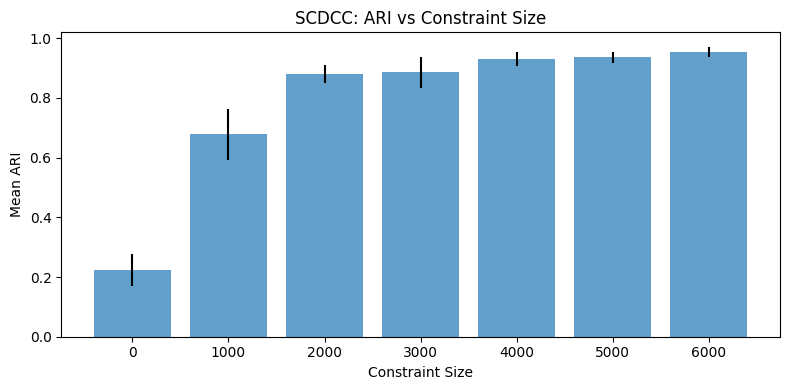

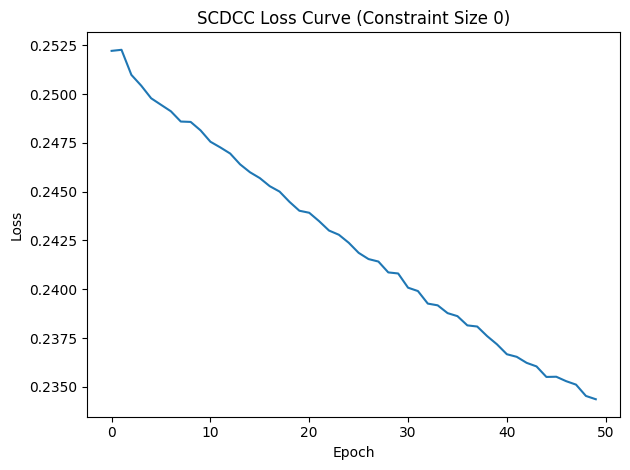

=== Visualizing constraint size: 0 ===


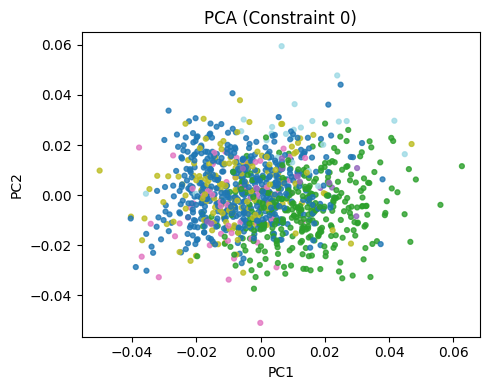

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


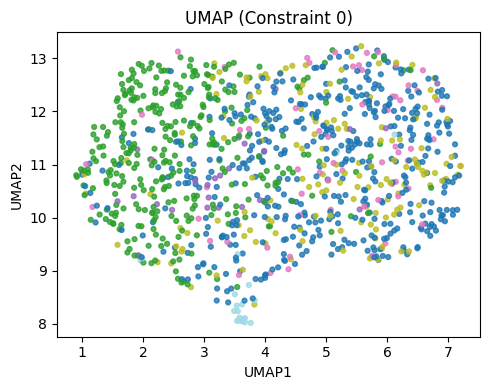

=== Visualizing constraint size: 1000 ===


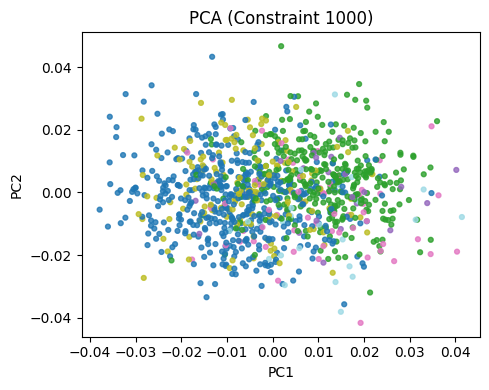

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


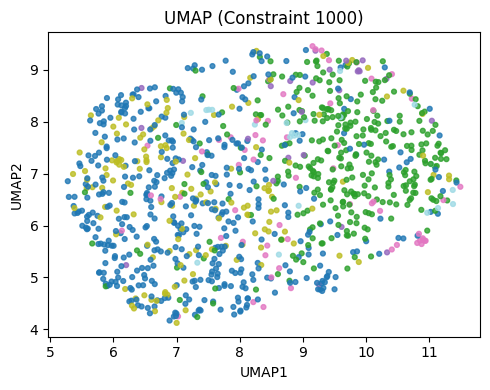

=== Visualizing constraint size: 2000 ===


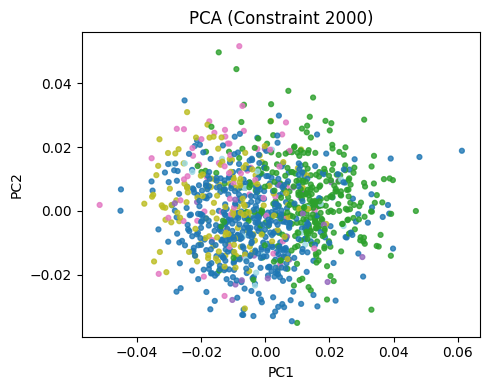

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


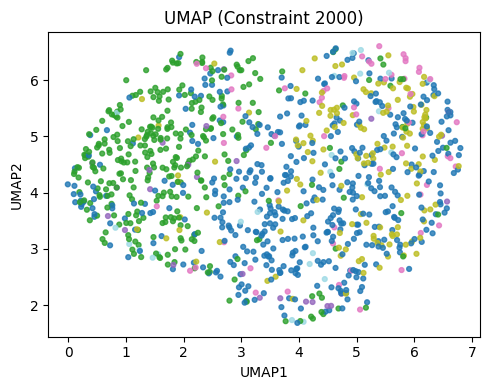

=== Visualizing constraint size: 3000 ===


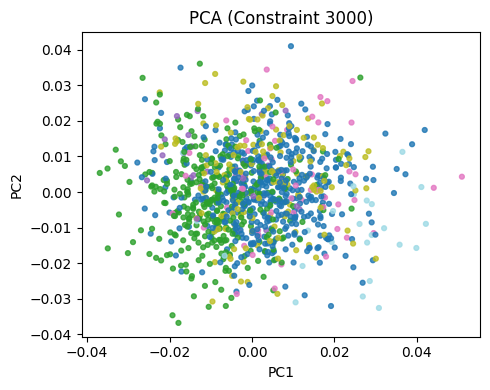

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


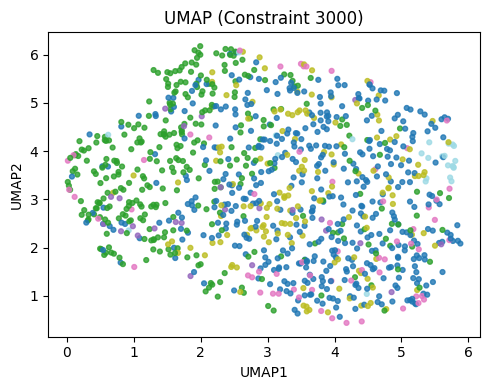

=== Visualizing constraint size: 4000 ===


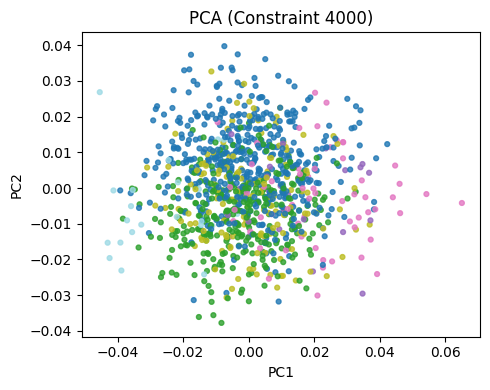

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


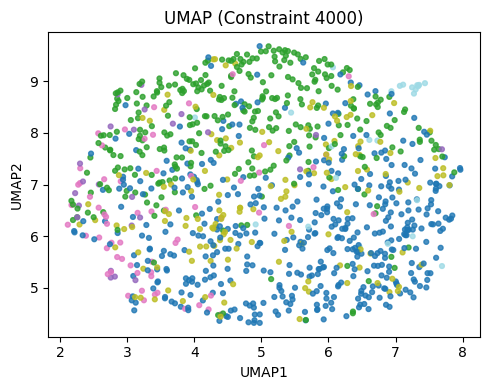

=== Visualizing constraint size: 5000 ===


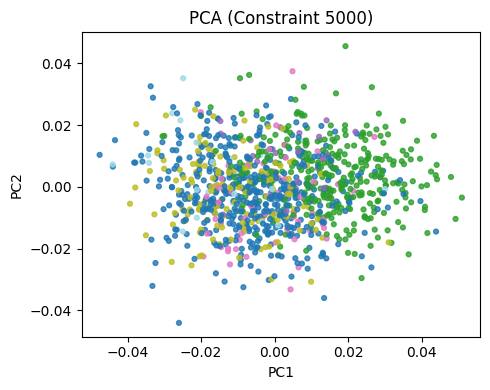

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


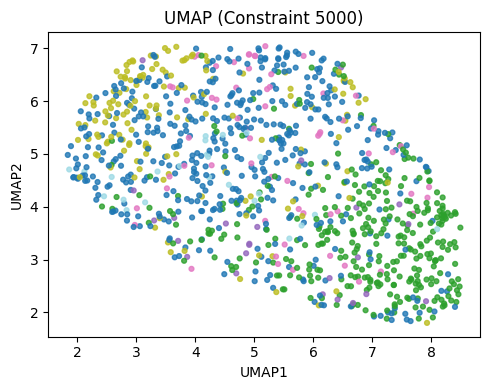

=== Visualizing constraint size: 6000 ===


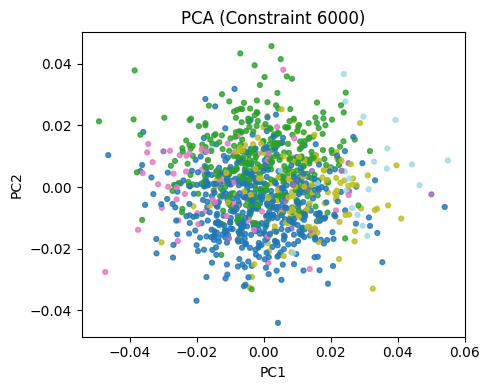

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


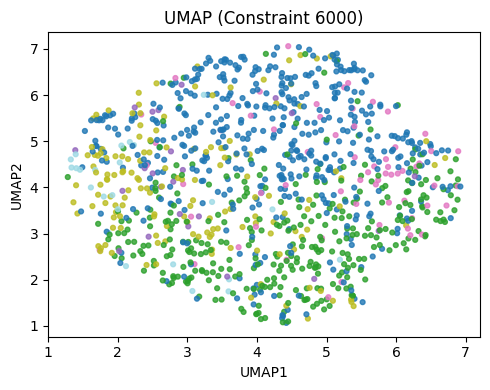

In [48]:

# Prepare arrays from AnnData objects -
X_train = adata_raw_train.X.astype(np.float32)
X_val   = adata_raw_val.X.astype(np.float32)
X_test  = adata_raw_test.X.astype(np.float32)

# Using factorize to map string labels to integer codes, and ensure consistent mapping
y_train, class_names = pd.factorize(adata_raw_train.obs["label"].astype(str).values)
y_val = pd.Categorical(adata_raw_val.obs["label"].astype(str).values, categories=class_names).codes
y_test = pd.Categorical(adata_raw_test.obs["label"].astype(str).values, categories=class_names).codes

print("Integer label mapping (use class_names[i] to get the cell type):")
for i, name in enumerate(class_names):
    print(f"{i}: {name}")

# Remaping constraints
cellname_to_idx = {name: i for i, name in enumerate(adata_raw_train.obs_names)}
def remap_pairs(pairs, mapping):
    return [(mapping[i], mapping[j]) for i, j in pairs if i in mapping and j in mapping]

constraints_idx = {
    size: {
        'must_link': remap_pairs(v['must_link'], cellname_to_idx),
        'cannot_link': remap_pairs(v['cannot_link'], cellname_to_idx)
    }
    for size, v in constraints.items()
}

#  Runing SCDCC 
middle_idx = len(constraints_idx) // 2
results = run_full_scdcc_pipeline(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    constraints_idx,
    latent_dims=[10, 20, 50],
    lrs=[1e-3, 5e-4],
    pretrain_epochs=50,
    train_epochs=50,
    n_repeats=10,
    alpha=1.0, beta=5.0, margin=2.0,
    tune_constraint_index=middle_idx
)

# Results
df = pd.DataFrame(results).T
display(df)

# Ploting ARI mean vs constraint size 
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.bar(df.index.astype(str), df["ARI_mean"], yerr=df["ARI_std"], alpha=0.7, label='ARI')
plt.title("SCDCC: ARI vs Constraint Size")
plt.xlabel("Constraint Size")
plt.ylabel("Mean ARI")
plt.tight_layout()
plt.show()

#  Ploting training loss curve 
first_size = list(results.keys())[0]
plt.plot(results[first_size]['loss_curves'][0])
plt.title(f'SCDCC Loss Curve (Constraint Size {first_size})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

#2D PCA/UMAP/Latent Visualization for Each Constraint Size 
from sklearn.decomposition import PCA
import umap

for size in results:
    print(f"=== Visualizing constraint size: {size} ===")
    # We'll just run a model again to get embeddings. You can save them during training if you want.
    model = scDCC(input_dim=X_train.shape[1], latent_dim=20).to(device)
    model.eval()
    with torch.no_grad():
        _, _, _, z_test = model(torch.tensor(X_test, dtype=torch.float32, device=device))
    z_test = z_test.cpu().numpy()

    # PCA
    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z_test)
    plt.figure(figsize=(5,4))
    plt.scatter(z_pca[:,0], z_pca[:,1], c=y_test, cmap='tab20', s=12, alpha=0.8)
    plt.title(f"PCA (Constraint {size})")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

    # UMAP
    reducer = umap.UMAP(n_components=2, random_state=42)
    z_umap = reducer.fit_transform(z_test)
    plt.figure(figsize=(5,4))
    plt.scatter(z_umap[:,0], z_umap[:,1], c=y_test, cmap='tab20', s=12, alpha=0.8)
    plt.title(f"UMAP (Constraint {size})")
    plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
    plt.tight_layout()
    plt.show()


In [52]:
# SCDCC,  mean ± std from best constraint size
best_size = max(results, key=lambda k: results[k]['ARI_mean'])
scdcc_ari = results[best_size]['ARI_mean']
scdcc_ari_std = results[best_size]['ARI_std']
scdcc_nmi = results[best_size]['NMI_mean']
scdcc_nmi_std = results[best_size]['NMI_std']
scdcc_ca = results[best_size]['CA_mean']
scdcc_ca_std = results[best_size]['CA_std']

# KMeans and DEC, Values
kmeans_ari = kmeans_results["ARI"]
kmeans_nmi = kmeans_results["NMI"]
kmeans_ca  = kmeans_results["CA"]

dec_ari = dec_results["ARI"]
dec_nmi = dec_results["NMI"]
dec_ca  = dec_results["CA"]


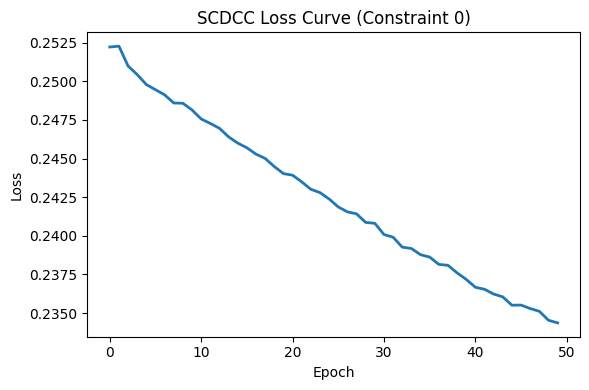

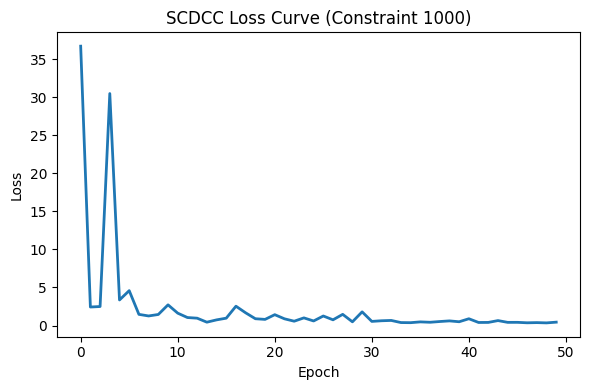

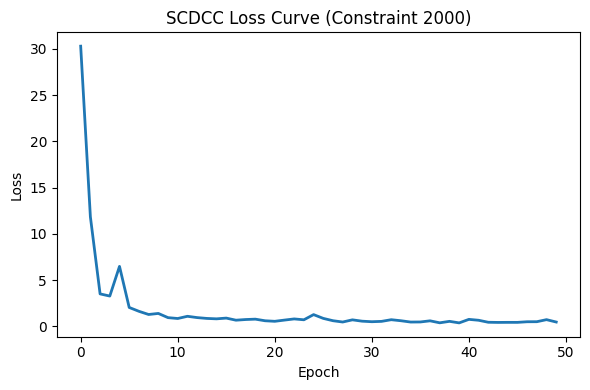

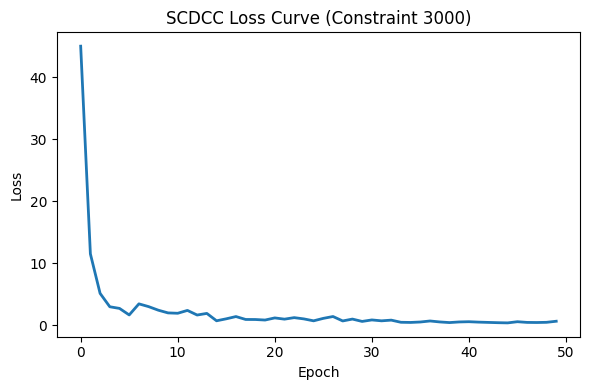

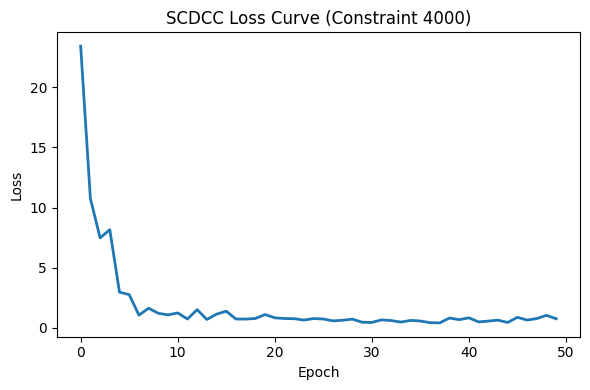

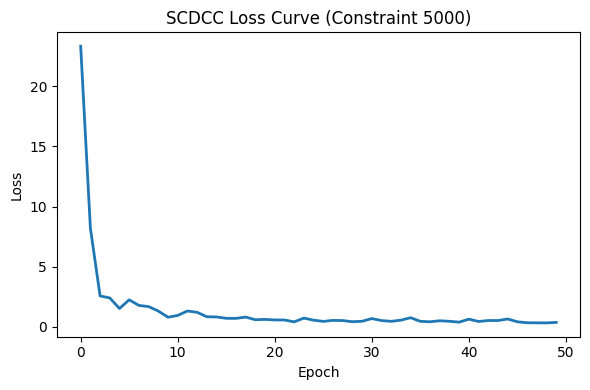

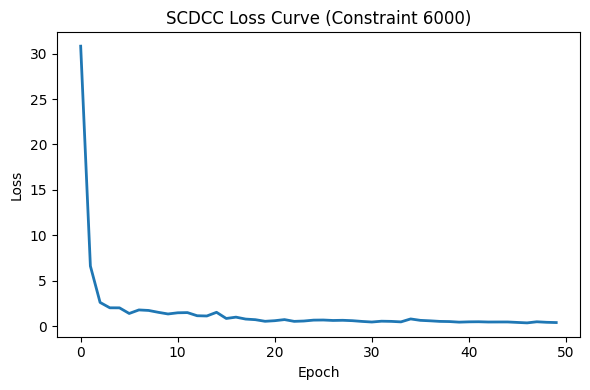

In [53]:
for size in results:
    loss_curve = results[size]['loss_curves'][0]  # first run, or loop for more
    plt.figure(figsize=(6,4))
    plt.plot(loss_curve, lw=2)
    plt.title(f"SCDCC Loss Curve (Constraint {size})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.show()


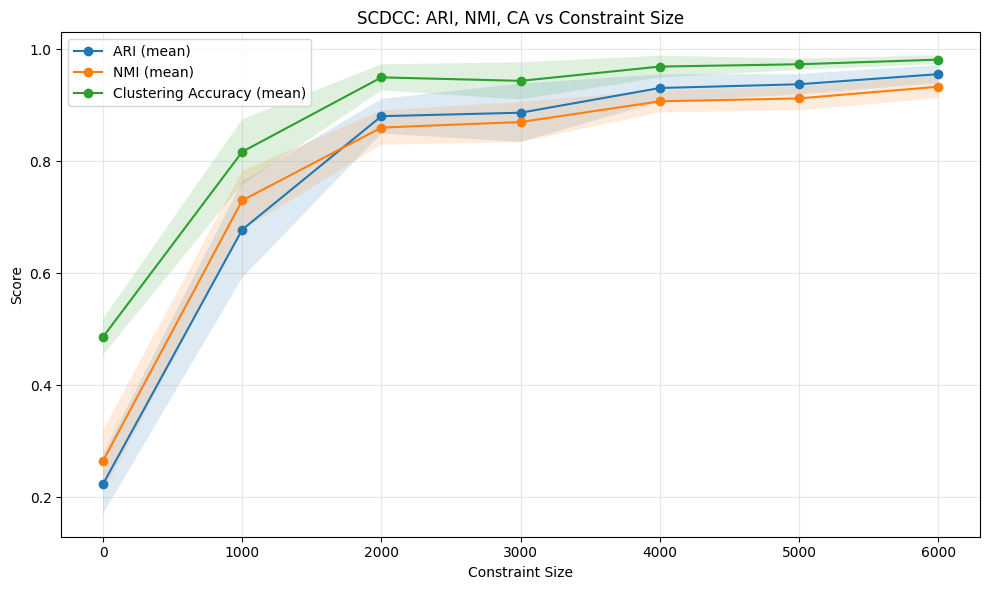

In [54]:

#Plotting line graph
metrics = [
    ("ARI_mean", "ARI_std", "ARI"),
    ("NMI_mean", "NMI_std", "NMI"),
    ("CA_mean",  "CA_std",  "Clustering Accuracy"),
]

sizes = list(results.keys())
sizes_int = [int(s) for s in sizes]
sort_idx = np.argsort(sizes_int)
sorted_sizes = [sizes[i] for i in sort_idx]
size_ticks = [int(s) for s in sorted_sizes]

plt.figure(figsize=(10, 6))
for mean_key, std_key, display_name in metrics:
    means = [results[s][mean_key] for s in sorted_sizes]
    stds  = [results[s][std_key]  for s in sorted_sizes]
    plt.plot(size_ticks, means, marker='o', label=f"{display_name} (mean)")
    plt.fill_between(size_ticks,
                     np.array(means) - np.array(stds),
                     np.array(means) + np.array(stds),
                     alpha=0.15)

plt.title("SCDCC: ARI, NMI, CA vs Constraint Size")
plt.xlabel("Constraint Size")
plt.ylabel("Score")
plt.xticks(size_ticks)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


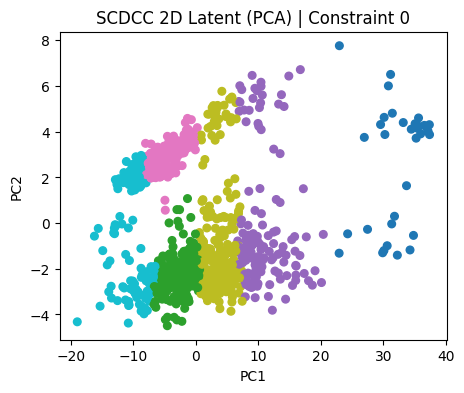

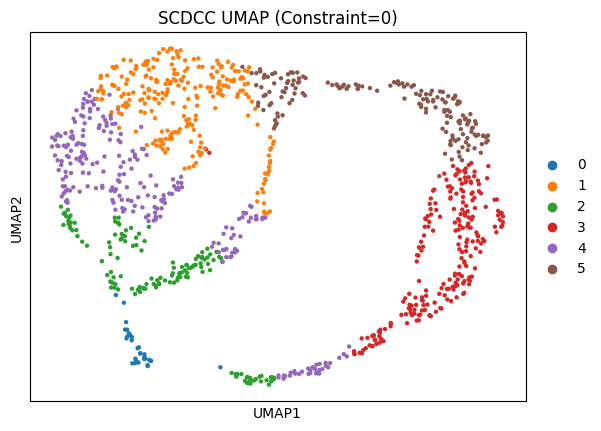

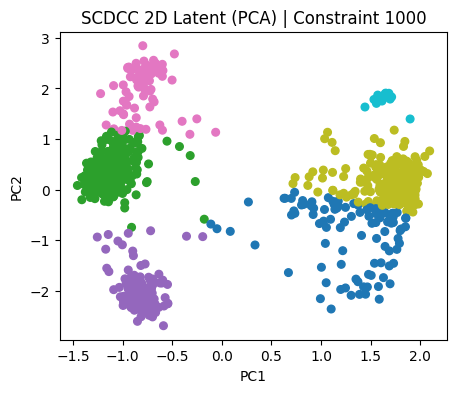

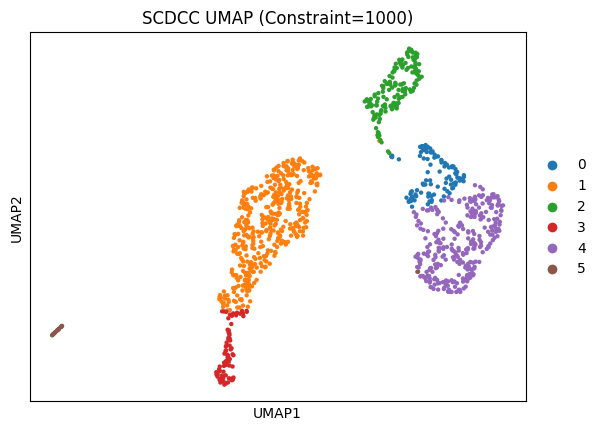

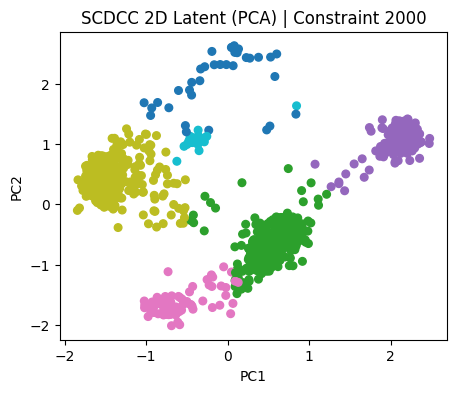

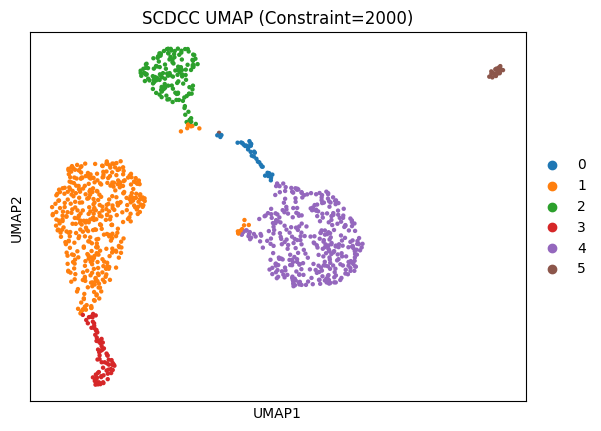

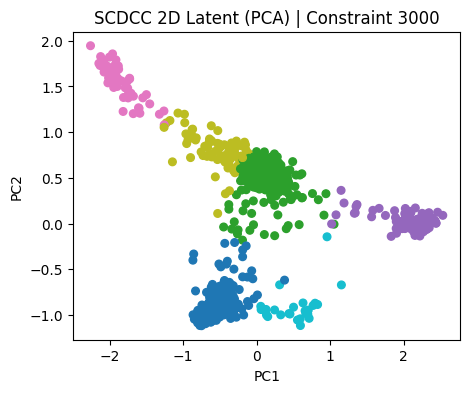

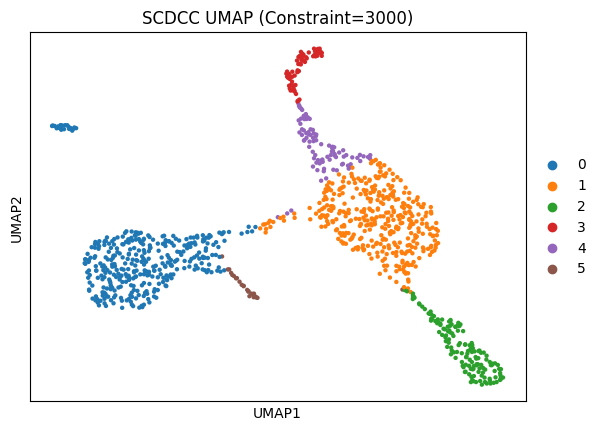

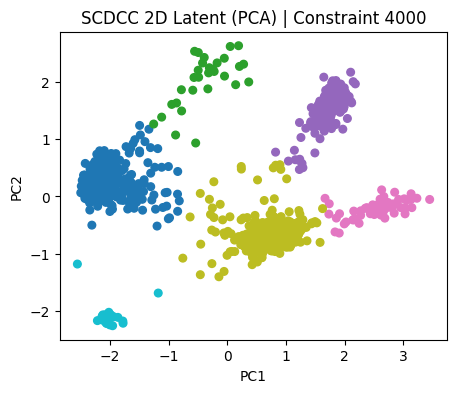

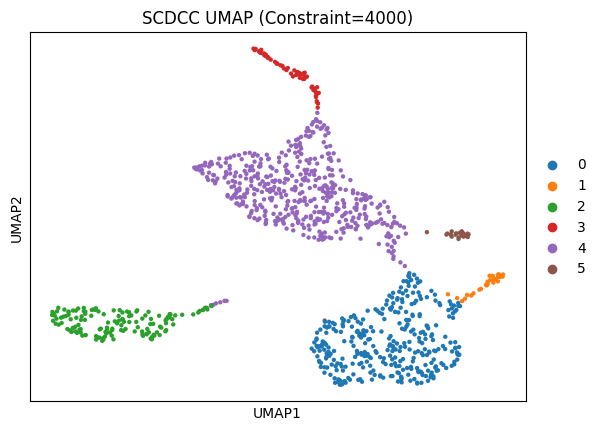

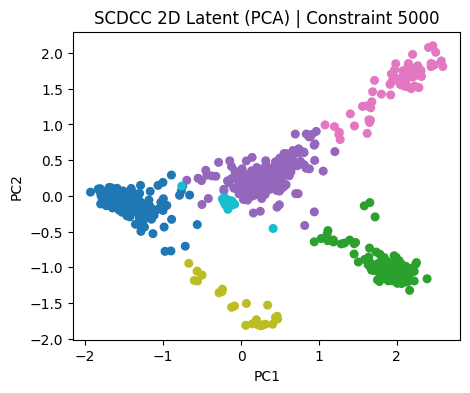

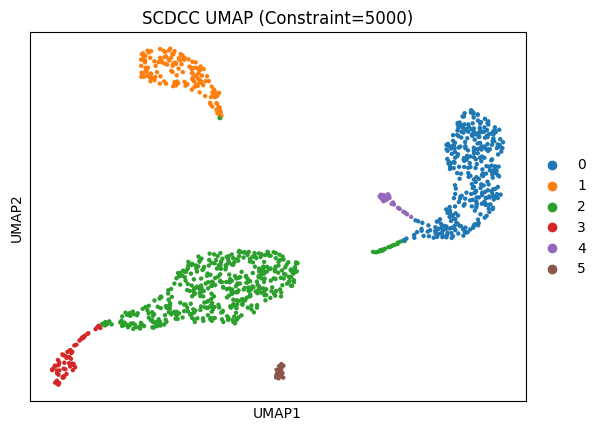

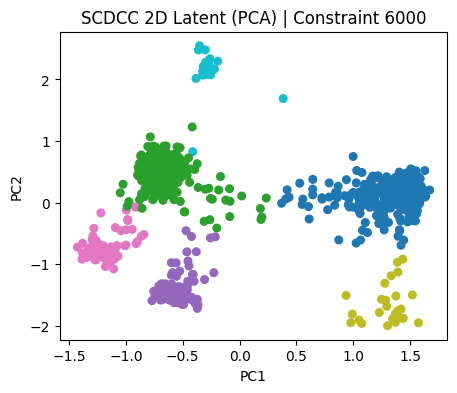

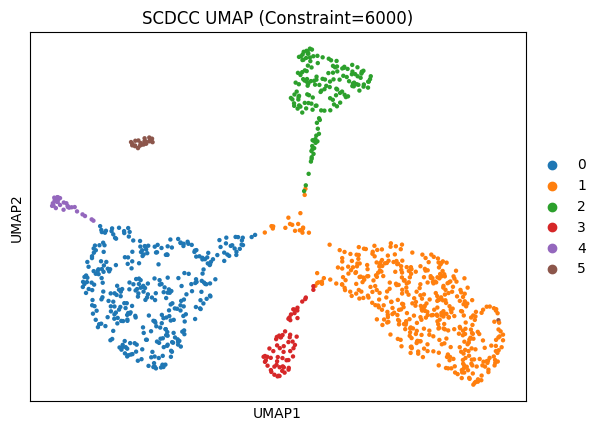

In [55]:

# For each constraint size,  2D PCA and UMAP for the first run
for size in results:
    z_test = results[size]['z_tests'][0]
    preds = results[size]['test_preds'][0]

    # 2D PCA
    z_2d = PCA(n_components=2).fit_transform(z_test)
    plt.figure(figsize=(5,4))
    plt.scatter(z_2d[:,0], z_2d[:,1], c=preds, cmap='tab10', s=30)
    plt.title(f"SCDCC 2D Latent (PCA) | Constraint {size}")
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.show()

    # UMAP
    adata = sc.AnnData(z_test)
    adata.obs['cluster'] = pd.Categorical(preds.astype(str))
    sc.pp.neighbors(adata, use_rep='X')
    sc.tl.umap(adata)
    sc.pl.umap(adata, color='cluster', title=f"SCDCC UMAP (Constraint={size})", size=40)


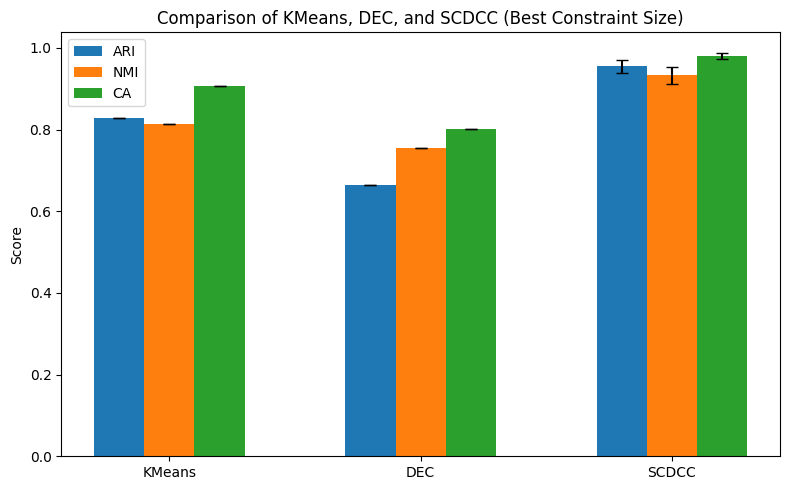

In [56]:
# Bar plot visualsation
methods = ['KMeans', 'DEC', 'SCDCC']
ari_scores = [kmeans_ari, dec_ari, scdcc_ari]
ari_errs = [0, 0, scdcc_ari_std]  # only SCDCC has std (if you want to plot it)
nmi_scores = [kmeans_nmi, dec_nmi, scdcc_nmi]
nmi_errs = [0, 0, scdcc_nmi_std]
ca_scores = [kmeans_ca, dec_ca, scdcc_ca]
ca_errs = [0, 0, scdcc_ca_std]

x = np.arange(len(methods))
width = 0.2

plt.figure(figsize=(8, 5))
plt.bar(x - width, ari_scores, width, yerr=ari_errs, capsize=4, label='ARI')
plt.bar(x, nmi_scores, width, yerr=nmi_errs, capsize=4, label='NMI')
plt.bar(x + width, ca_scores, width, yerr=ca_errs, capsize=4, label='CA')
plt.xticks(x, methods)
plt.ylabel("Score")
plt.title("Comparison of KMeans, DEC, and SCDCC (Best Constraint Size)")
plt.legend()
plt.tight_layout()
plt.show()


In [57]:
#Sumary of results of Kmeans,DEC and SCDCC
summary = pd.DataFrame({
    'ARI': ari_scores,
    'NMI': nmi_scores,
    'CA': ca_scores
}, index=methods)


summary_std = pd.DataFrame({
    'ARI': ari_errs,
    'NMI': nmi_errs,
    'CA': ca_errs
}, index=methods)

print("=== Clustering Metrics Comparison (Best Constraint Size for SCDCC) ===")
print(summary)
if any(s > 0 for s in ari_errs + nmi_errs + ca_errs):
    print("\n(Standard deviations where available):")
    print(summary_std)


=== Clustering Metrics Comparison (Best Constraint Size for SCDCC) ===
             ARI       NMI        CA
KMeans  0.829336  0.813985  0.906955
DEC     0.663825  0.755442  0.802632
SCDCC   0.955173  0.932764  0.981109

(Standard deviations where available):
            ARI       NMI        CA
KMeans  0.00000  0.000000  0.000000
DEC     0.00000  0.000000  0.000000
SCDCC   0.01622  0.020405  0.007801
